In [1]:
# this cell is required to run these notebooks on Binder. Make sure that you also have a desktop tab open.
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    os.environ['DISPLAY'] = ':1.0'

In [204]:
#file navigation tools
from glob import glob
import os
#image analysis library
from skimage import io
#jupyter notebook img display
import stackview
#The fundamental package for scientific computing with Python
import numpy as np
#python image viewer 
import napari
#excel for python
import pandas as pd
import csv

import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot

import cv2 as cv
from typing import List


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

import shapely 
from shapely import Point, Polygon
from shapely import intersection
from shapely import wkt

In [205]:
# =============================================================================
# This function allows you to ask a yes or no question which either returns a 
# counter 'y' or 'n'. I use this in other functions when deciding to interact 
# with the user. I have usually used this to exit a while True: loop
# =============================================================================
def yes_or_no(question):
    counter = ''
    while counter == '':
        #The user is asked a yes or no question.
        user = input('\n\n!!!\n'+question+'(y/n)\n!!!\n')
        #If they don't either input yes or no in the accepted format the while loop is not broken.
        if user.lower() in ['yes', 'y']:
            counter += 'y'
            #While loop broken and programme run can continue.
            return counter
        elif user.lower() in ['no', 'n']:
            counter+='n'
            #While loop broken and programme run can continue.
            return counter
        else:
            print_info('I\'m sorry I don\'t understand... Please enter (y\\n) in the accepted format')

In [206]:
# =============================================================================
# This function calculates the Laplacian variance of an image. 
# =============================================================================
def lap_variance(img):
    return np.var(cv.Laplacian(img, cv.CV_64F, ksize=21))

In [207]:
# =============================================================================
# This function uses the lap_variance function to calulcate the Laplacian
# variance for each slice in a stack and returns which slice (the index) of 
# the slice with the maximum variance.
# =============================================================================
def best_focus_z_slice_id(channel):
    lap_var_z_slice = []
    for img in channel:
        lap_var_z_slice.append(lap_variance(img)) 
    max_var = max(lap_var_z_slice)
    max_var_id = lap_var_z_slice.index(max_var)
    return max_var_id

In [353]:
# =============================================================================
# This function takes the path of a z-stack tif file and splits the stack
# in this case into 4 channels with 41 slices in each.
# =============================================================================
def read_stack(path_array):
    img = io.imread(path_array[0], plugin='pil')
    img = np.expand_dims(img,1)
    img = np.reshape(img,(4,41,2304,2304))
    return path_array, img

In [209]:
# =============================================================================
# This function returns the 21 most in focus slices by adding and subtracting 
# 10 from the index of the slice with the maximum variance - a very simple 
# method.
# =============================================================================
def choose_focus_lap(channel_stack):
    focus = [best_focus_z_slice_id(channel_stack)-10, best_focus_z_slice_id(channel_stack)+10]
    #BIGFISH
    #focus = stack.compute_focus(img[i], neighborhood_size=31)
    return focus

In [210]:
# =============================================================================
# This function computes the maximum intesnity projection using the 'most in-fo
# cus' slices. These focussed slices can be input manually or calculated via
# some method.
# =============================================================================
def np_mip(channel_array, focus):
    return np.amax(channel_array[focus[0]:focus[1],...],axis=0,keepdims=False)

In [211]:
# =============================================================================
# This function is a simple wrapper for a bigfish function removing the 
# background of an image - currently unused in the script.
# =============================================================================
def projection_filter(channel_projection):
    return stack.remove_background_gaussian(channel_projection, sigma=3)

In [212]:
# =============================================================================
# This function opens the napari viewer with the Maximum Intensity Projections 
# (MIP) of the channels.
# =============================================================================
def napari_view(files, zproject, channels=['CY5', 'CY3', 'CY3.5', 'DAPI'], colors=['magenta', 'green', 'cyan', 'blue']):
    viewer= napari.Viewer()
    viewer.add_image(io.imread(files[1]), name='DIC', opacity=0.30)
    for i in range(zproject.shape[0]):
        viewer.add_image(zproject[i,...],name=channels[i],colormap=colors[i],opacity=0.90)

In [346]:
# =============================================================================
# This function opens the napari viewer with the MIPs with the corresponding 
# spots for each channel.
# =============================================================================
def napari_view_spots(files, zproject, spots, channels=['CY5', 'CY3', 'CY3.5', 'DAPI'], colors=['magenta', 'green', 'cyan', 'blue']):
    #viewer= napari.Viewer()
    viewer.add_image(io.imread(files[1]), name='DIC', opacity=0.30)
    for i in range(zproject.shape[0]):
        viewer.add_image(zproject[i,...],name=channels[i],colormap=colors[i],opacity=0.90)
        #if channels[i] == 'CY3':
        #coordinates_2d = spots['rna_coord'][:, 1:]
        coordinates_2d=spots
        viewer.add_points(coordinates_2d, name=str(channels[i])+' spot', opacity=0.7, edge_color='red', face_color='transparent')

In [214]:
# =============================================================================
# This function opens the napari viewer with the MIPs with the corresponding 
# spots for each channel with the corresponding masks.
# =============================================================================
def napari_view_masks(files, masks, zproject, spots, channels=['CY5', 'CY3', 'CY3.5', 'DAPI'], colors=['magenta', 'green', 'cyan', 'blue']):
        napari_view_spots(files, zproject, spots)
        viewer.add_image(io.imread(masks),name='Cellpose',opacity=0.90)

In [215]:
# =============================================================================
# This function uses the Bigfish detection.detect_spots to compute the coordinates
# of RNA spots for each of the channels that is not the DAPI channel.
# Returns a dictionary of each of the channels and the spot coordinates.
# =============================================================================
def spot_coord(stack, voxel_size=(200, 64.5, 64.5), spot_radius=(200, 70, 70), channels=['CY5', 'CY3', 'CY3.5', 'DAPI']):
    coordinate_dict = {}
    for i in range(len(stack)):
        if channels[i] != 'DAPI':
            spots, threshold = detection.detect_spots(images=stack_example[i], return_threshold=True, 
            voxel_size=voxel_size, spot_radius=spot_radius)
            coordinate_dict[channels[i]] = spots
    return coordinate_dict

In [219]:
# =============================================================================
# This function assigns the dictionary of spot coordinates to each of the cells
# defined by the cell masks.
# =============================================================================
def spot_per_cell(coordinate_dict, first_channel, mask_path, mip_dict):
    coordinate_dict_other = {key: coordinate_dict[key] for key in coordinate_dict if key != first_channel}
    cell_label = io.imread(mask_path, plugin='pil')
    percell_results = multistack.extract_cell(cell_label=cell_label, 
                        ndim=3, nuc_label=None, rna_coord=coordinate_dict[first_channel], 
                        others_coord=coordinate_dict_other,
                        image=mip_dict[first_channel], 
                        others_image=mip_dict)
    
    return percell_results

In [220]:
# =============================================================================
# This function returns the mask coordinates of the cells in the image.
# =============================================================================
def mask_coordinates(fov_results):
    cell_coords = []
    for i, cell_results in enumerate(fov_results):
        #(min_y, min_x, max_y, max_x)
        y = fov_results[i]['cell_coord'][:, 0] + fov_results[i]['bbox'][0]
        x = fov_results[i]['cell_coord'][:, -1] + fov_results[i]['bbox'][1]
        cell_coords.append(np.dstack((y, x))[0]) 
    return cell_coords

In [247]:
# =============================================================================
# This function converts the mask coordinates to represent their position 
# in the image.
# =============================================================================
def fov_coordinate_translator(i, fov_results):
    y = fov_results[i]['cell_coord'][:, 0] + fov_results[i]['bbox'][0]
    x = fov_results[i]['cell_coord'][:, -1] + fov_results[i]['bbox'][1]
    return np.dstack((y, x))[0]

In [348]:
# =============================================================================
# This function generally converts the coordinates - i.e. also spot coordinates
# to where they are in the image.
# =============================================================================
def fov_RNA_coordinate_translator(i, fov_results, channel):
    y = fov_results[i][channel][:, 1] + fov_results[i]['bbox'][0]
    x = fov_results[i][channel][:, -1] + fov_results[i]['bbox'][1]
    return np.dstack((y, x))[0]

In [217]:
path = "C:/Users/lotta/Documents/Bioinformatics_Msc/Project/DATA_INITIAL/pair_3"
#corresponding_files, stack_example = read_stack([f"{path}/yET915-SUN4Q570-SRL1CFR610-ASH1CLB2Q670_03_CY5, CY3.5 NAR, CY3, DAPI.tif",
#                                                 f"{path}/yET915-SUN4Q570-SRL1CFR610-ASH1CLB2Q670_03_DIC-100.tif"])

path = "C:/Users/lotta/Documents/Bioinformatics_Msc/Project/DATA_INITIAL/pair_2"
corresponding_files, stack_example = read_stack([f"{path}/yET563-SUN4Q570-SRL1CFR610-ASH1Q670_03_CY5, CY3.5 NAR, CY3, DAPI.tif",
                                                 f"{path}/yET563-SUN4Q570-SRL1CFR610-ASH1Q670_03_DIC-100.tif"])
projection = []
for i in stack_example:
    projection.append(np_mip(i, choose_focus_lap(i)))
napari_view(corresponding_files, np.array(projection))

In [218]:
np.array(projection).shape
spot_coord_dict = spot_coord(stack_example)

In [221]:
projection_dict = {'CY5':projection[0], 'CY3.5P':projection[1], 'CY3P':projection[2], 'DAPIP':projection[3]}

In [222]:
mask_sep = "C:/Users/lotta/Pictures/Cellpose/masks/pair3_pic_cp_masks.png"
mask_sep = "C:/Users/lotta/Pictures/Cellpose/pair2_sepmasks_21062023.png"
fov_sep = spot_per_cell(spot_coord_dict, 'CY5', mask1, projection_dict)
mask_sep_coords = mask_coordinates(fov_sep)

mask_whole = "C:/Users/lotta/Pictures/Cellpose/pair3_pic_whole_masks.png"
mask_whole = "C:/Users/lotta/Pictures/Cellpose/masks/pair3_pic_whole_masks.png"
mask_whole = "C:/Users/lotta/Pictures/Cellpose/pair2_wholemasks_21062023.png"
fov_whole = spot_per_cell(spot_coord_dict, 'CY5', mask2, projection_dict)
mask_whole_coords = mask_coordinates(fov_whole)

In [305]:
centroids = {}
for i in range(len(mask_sep_coords)):
    centroids[i] = [float(x) for x in Polygon(mask_sep_coords[i]).centroid.wkt[7:-2].split(' ')]
    
centroids[0]
mother_bud_sep = []
mother_bud_whole = []

for i in mask_whole_coords:
    counter_dict = {}
    for j in centroids.values():
        counter = shapely.contains_xy(Polygon(i), j[0], j[1])
        if counter == True:
            counter_dict[list(centroids.keys())[list(centroids.values()).index(j)]] = counter
    if len(counter_dict.values()) > 1:
        mother_bud_sep.append(list(counter_dict.keys()))
        mother_bud_whole.append(i)


In [306]:
mother_bud_dict = {}
for i in range(len(mother_bud_sep)):
    area1 = Polygon(fov_sep[mother_bud_sep[i][0]]['cell_coord']).area
    area2 = Polygon(fov_sep[mother_bud_sep[i][1]]['cell_coord']).area
    if area1 > area2:
        mother_bud_dict[mother_bud_sep[i][0]] = 'mother'
        mother_bud_dict[mother_bud_sep[i][1]] = 'bud'
    else:
        mother_bud_dict[mother_bud_sep[i][0]] = 'bud'
        mother_bud_dict[mother_bud_sep[i][1]] = 'mother'

# fov index : mother or bud
mother_bud_dict

{65: 'bud',
 66: 'mother',
 67: 'mother',
 68: 'bud',
 69: 'mother',
 70: 'bud',
 105: 'bud',
 106: 'mother',
 71: 'bud',
 72: 'mother',
 73: 'bud',
 74: 'mother',
 75: 'mother',
 76: 'bud',
 79: 'bud',
 80: 'mother',
 81: 'mother',
 82: 'bud',
 77: 'bud',
 78: 'mother',
 95: 'bud',
 96: 'mother',
 99: 'mother',
 100: 'bud',
 87: 'bud',
 88: 'mother',
 93: 'bud',
 94: 'mother',
 89: 'bud',
 90: 'mother',
 83: 'bud',
 84: 'mother',
 85: 'mother',
 86: 'bud',
 91: 'mother',
 92: 'bud',
 97: 'mother',
 98: 'bud',
 101: 'bud',
 102: 'mother',
 103: 'mother',
 104: 'bud'}

cell 65, bud
 number of rna 2


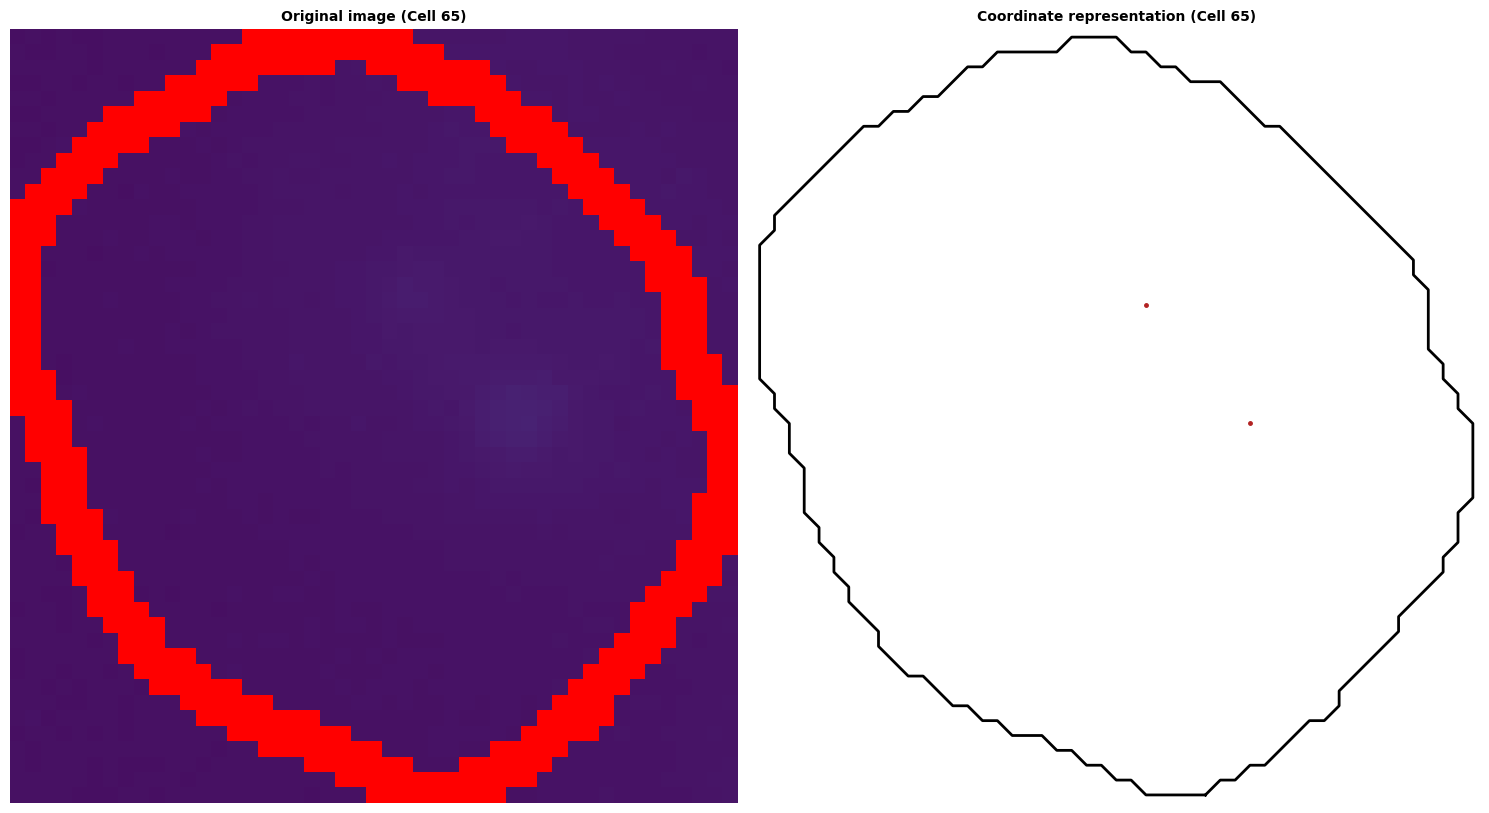

cell 66, mother
 number of rna 1


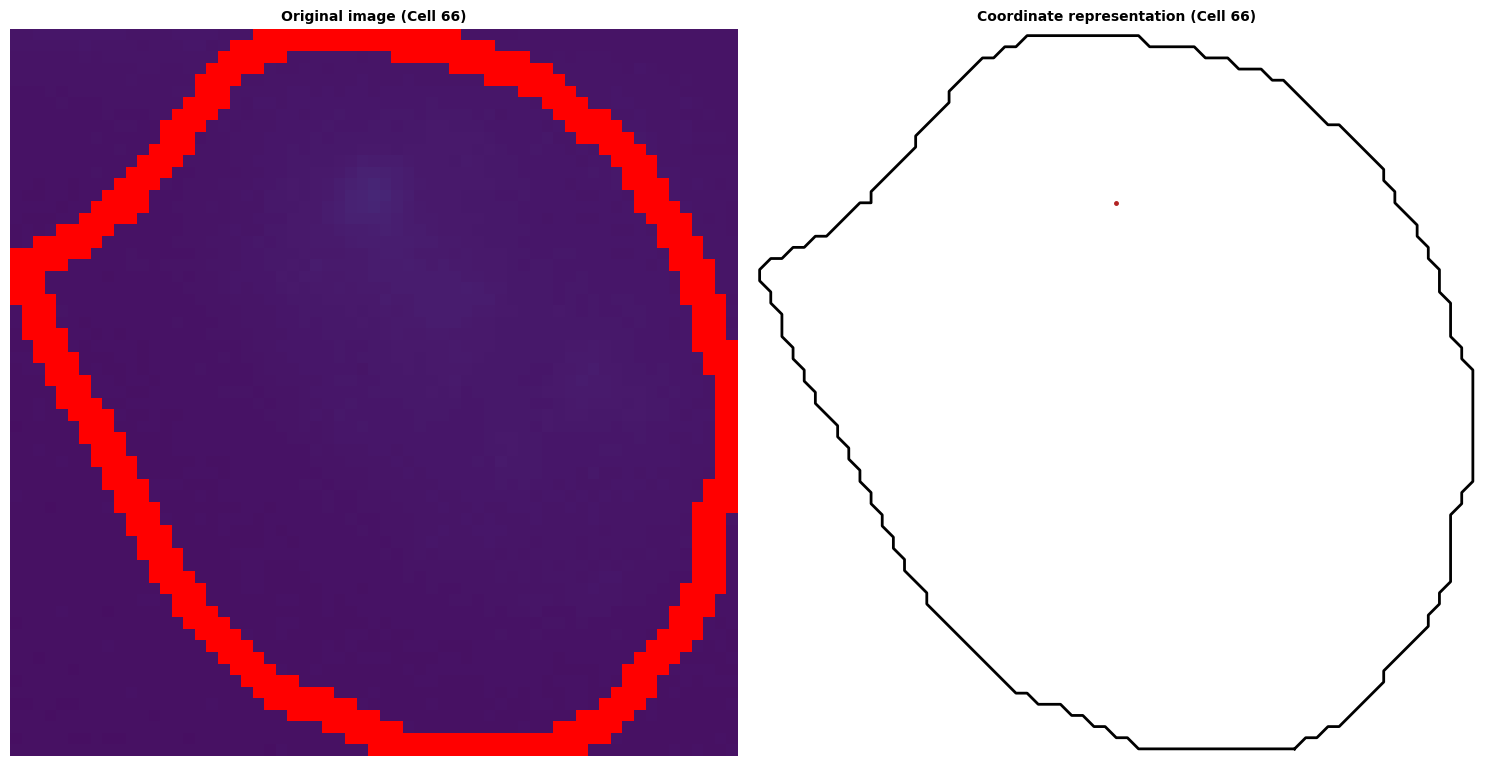

cell 67, mother
 number of rna 1


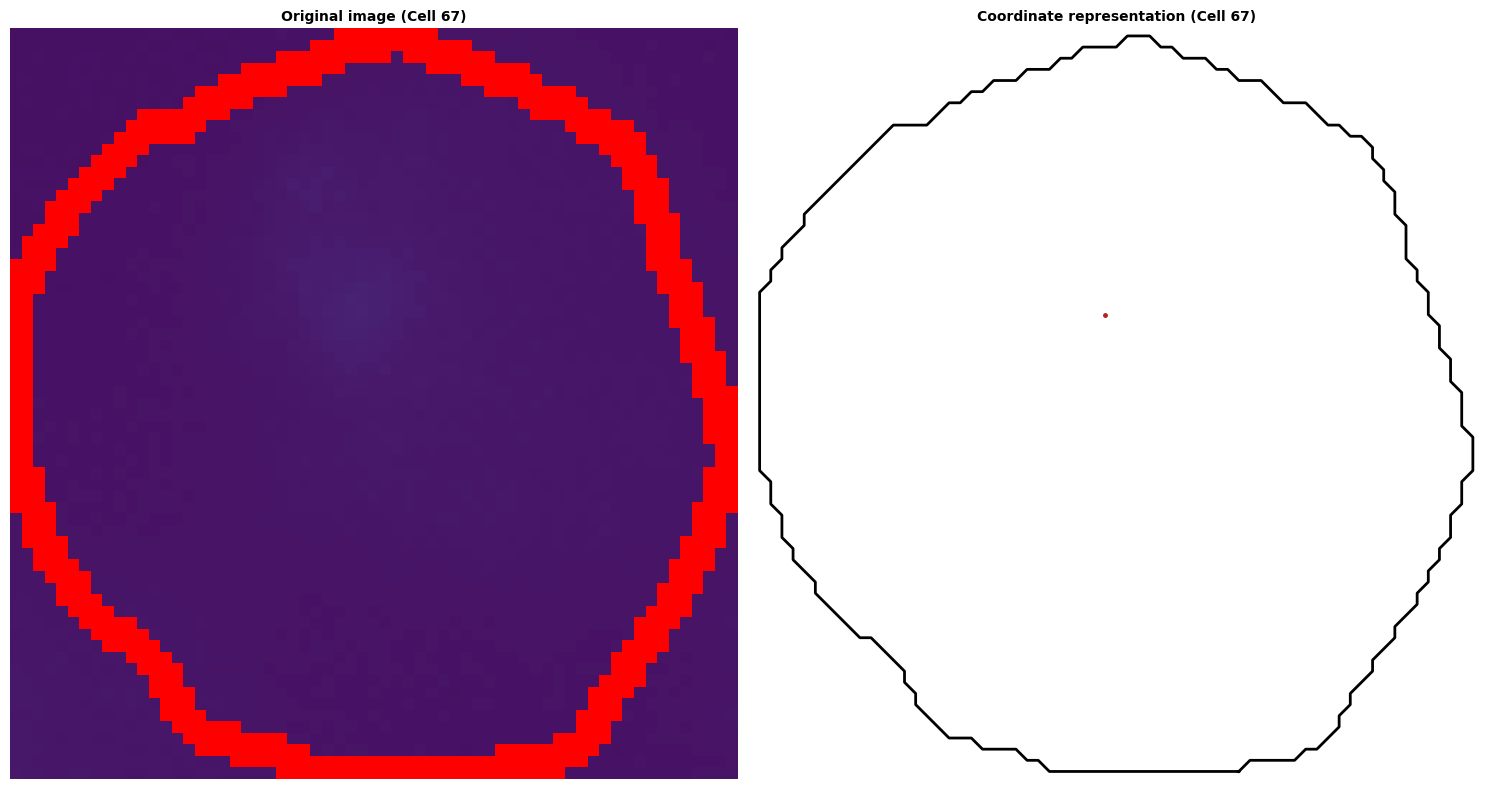

cell 68, bud
 number of rna 0


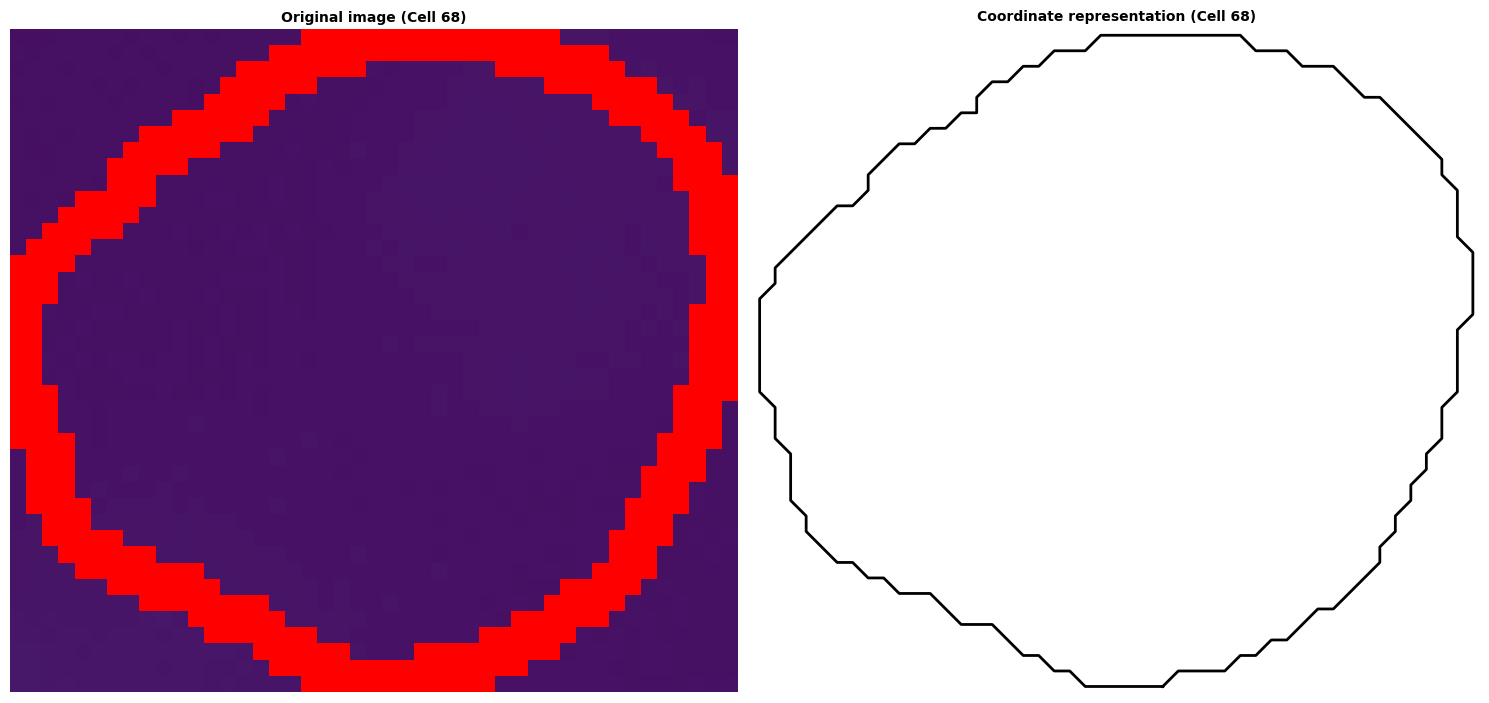

cell 69, mother
 number of rna 3


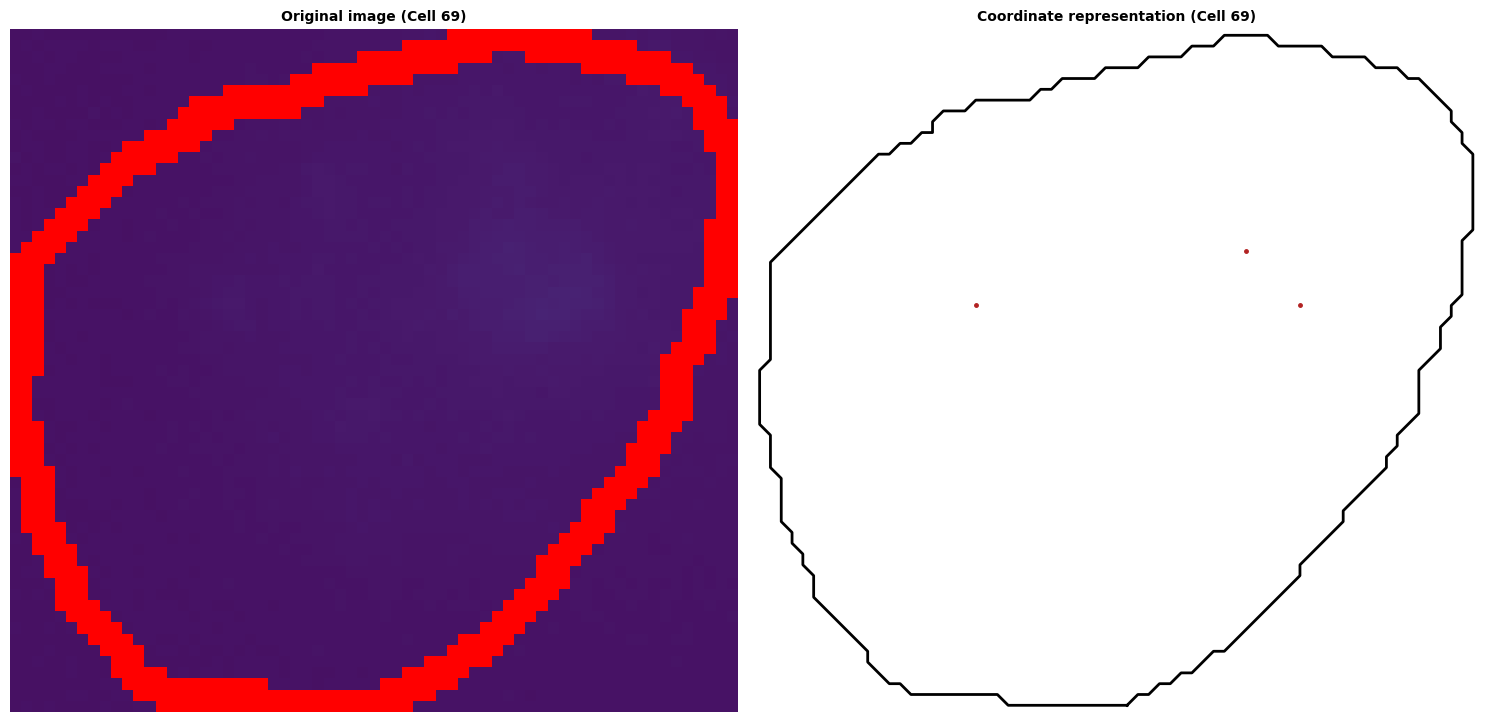

cell 70, bud
 number of rna 0


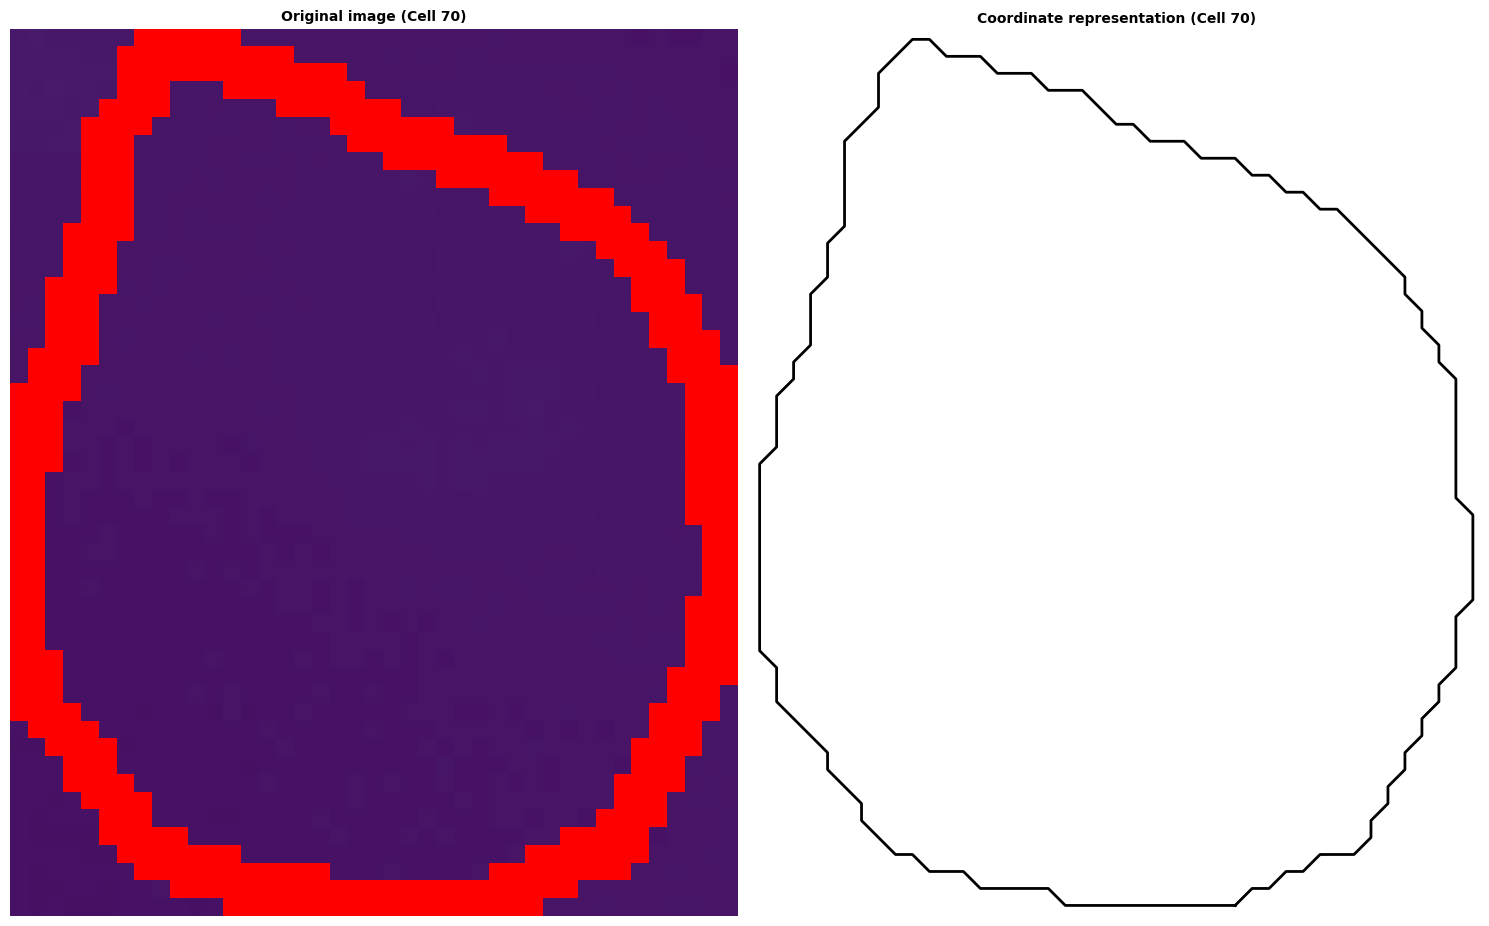

cell 105, bud
 number of rna 0


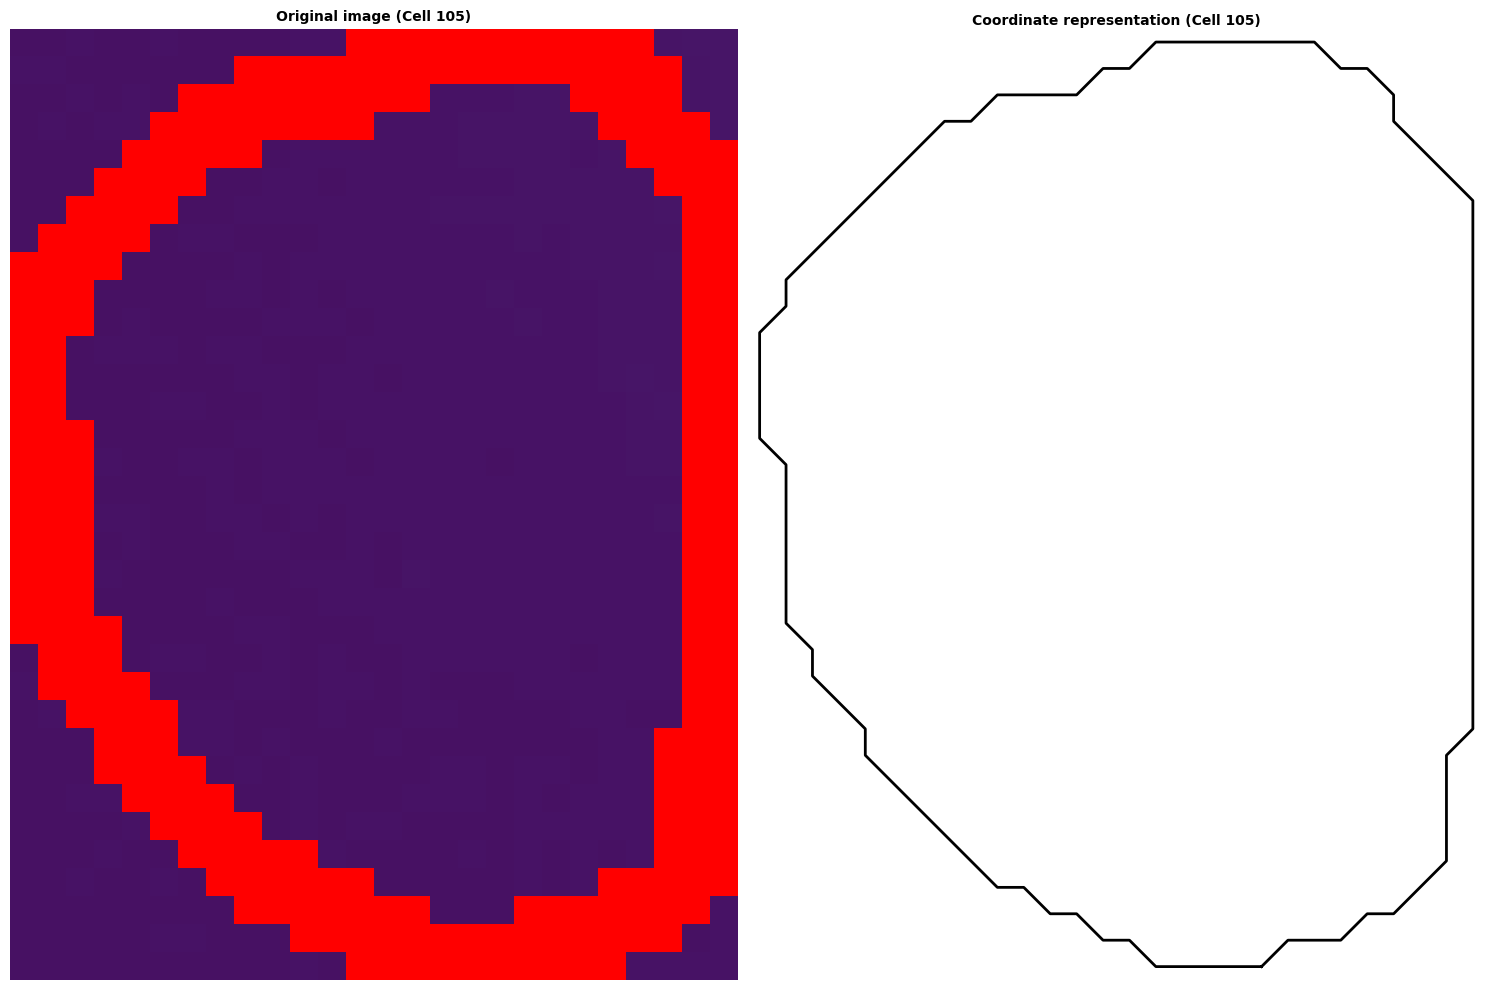

cell 106, mother
 number of rna 3


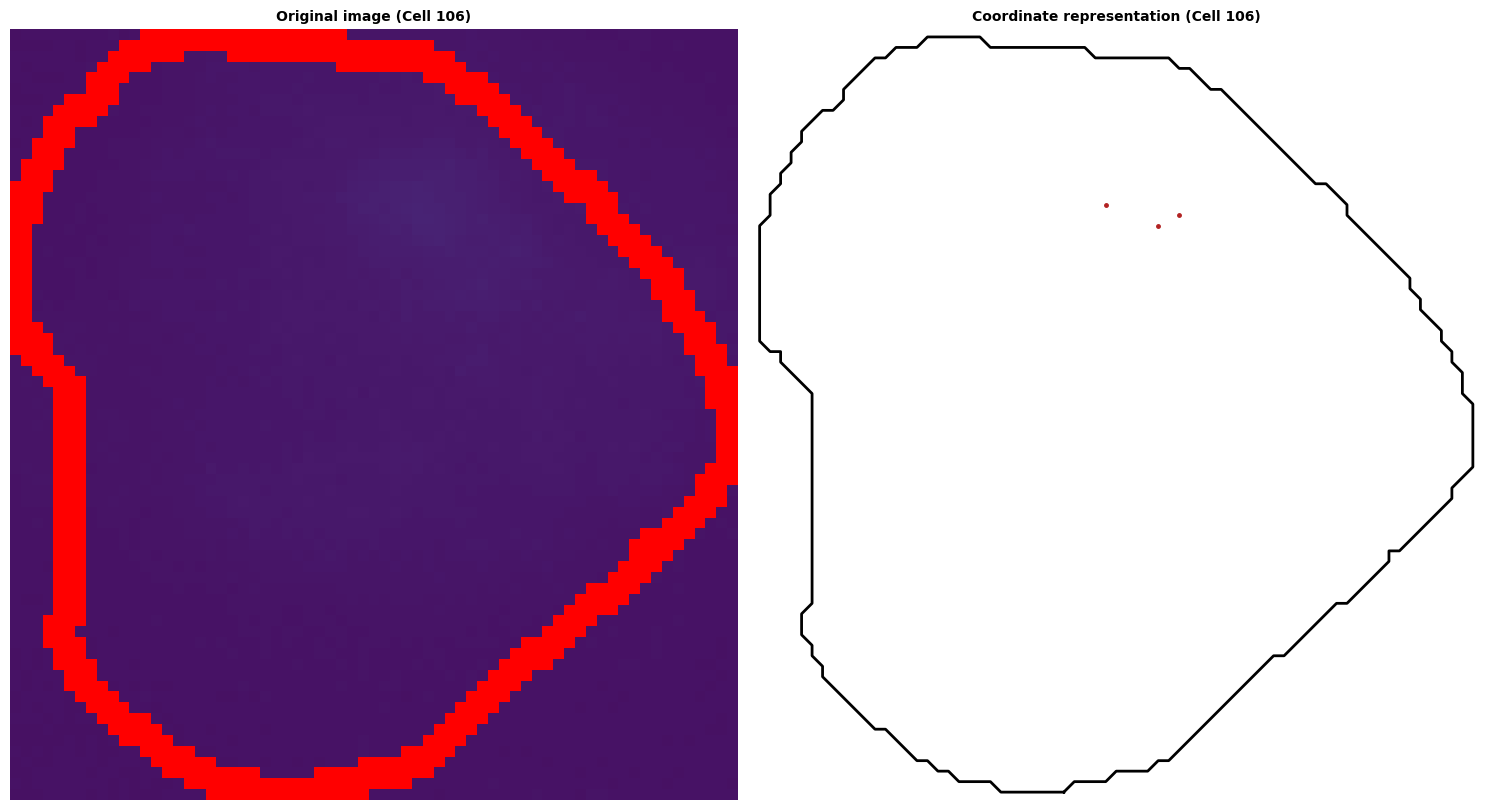

cell 71, bud
 number of rna 0


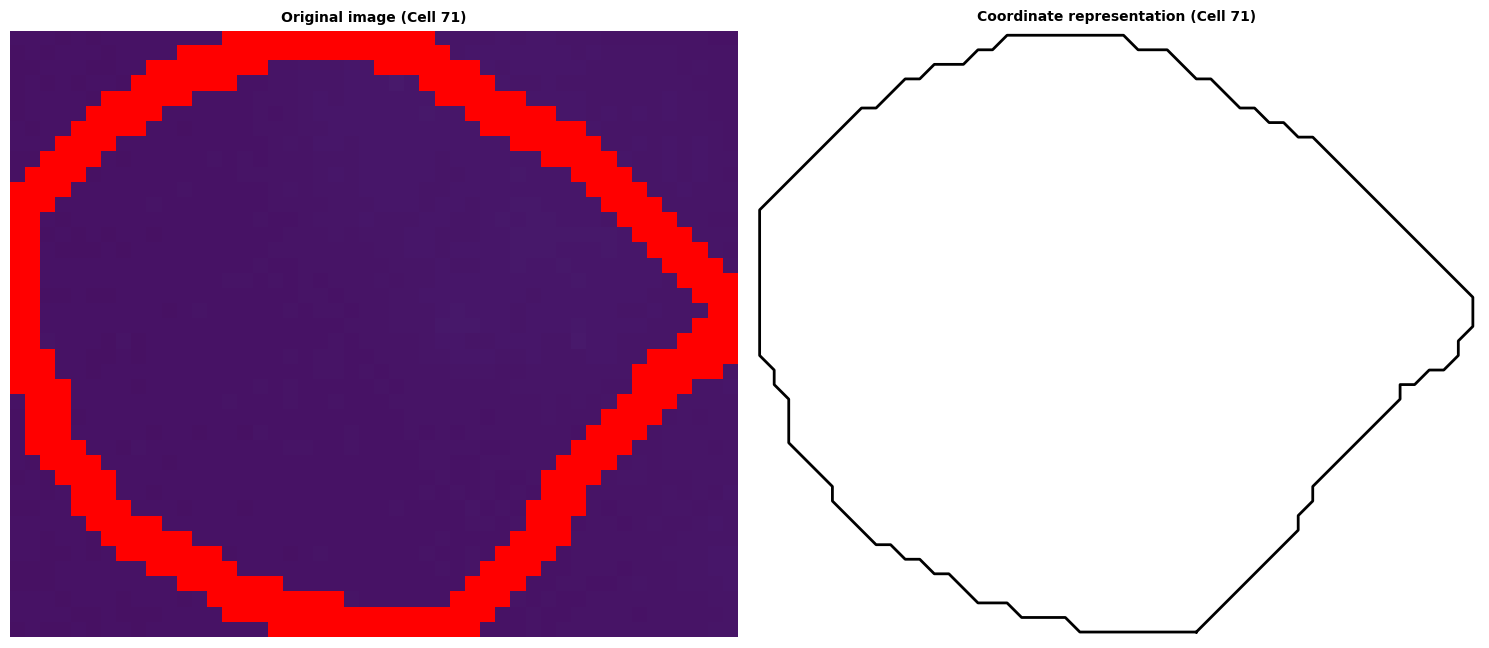

cell 72, mother
 number of rna 4


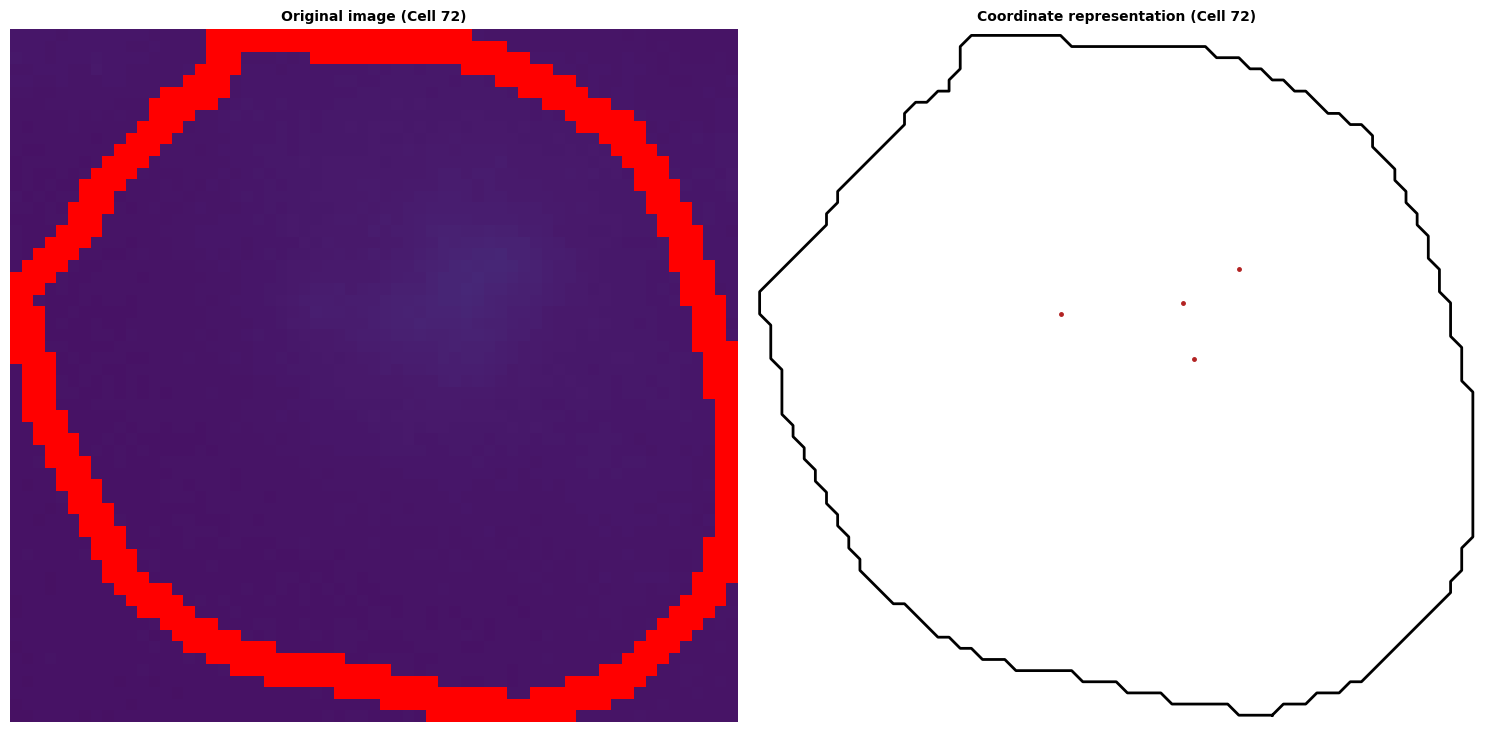

cell 73, bud
 number of rna 0


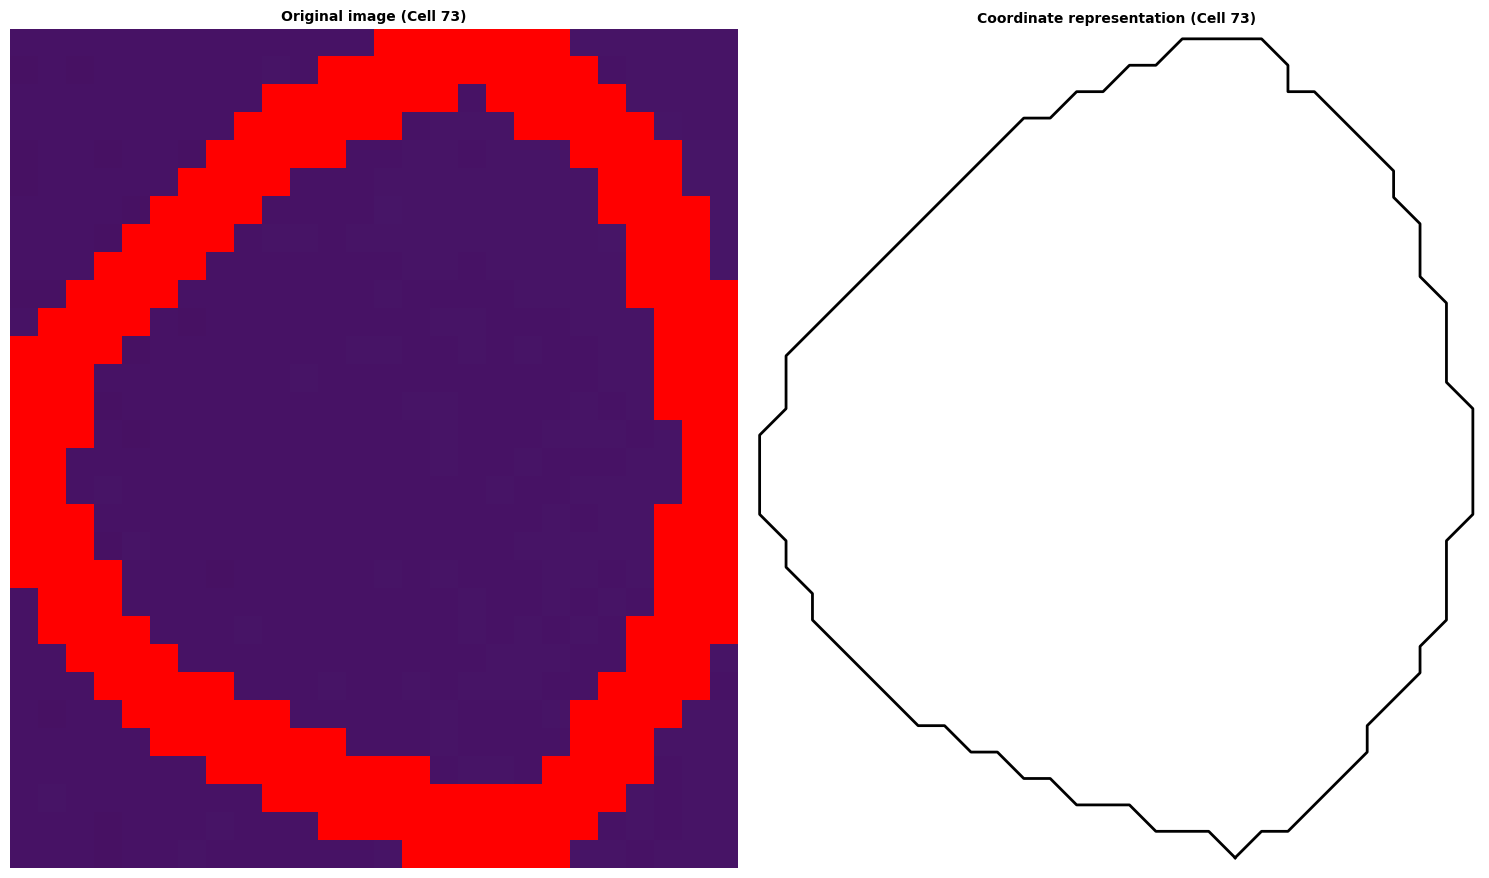

cell 74, mother
 number of rna 5


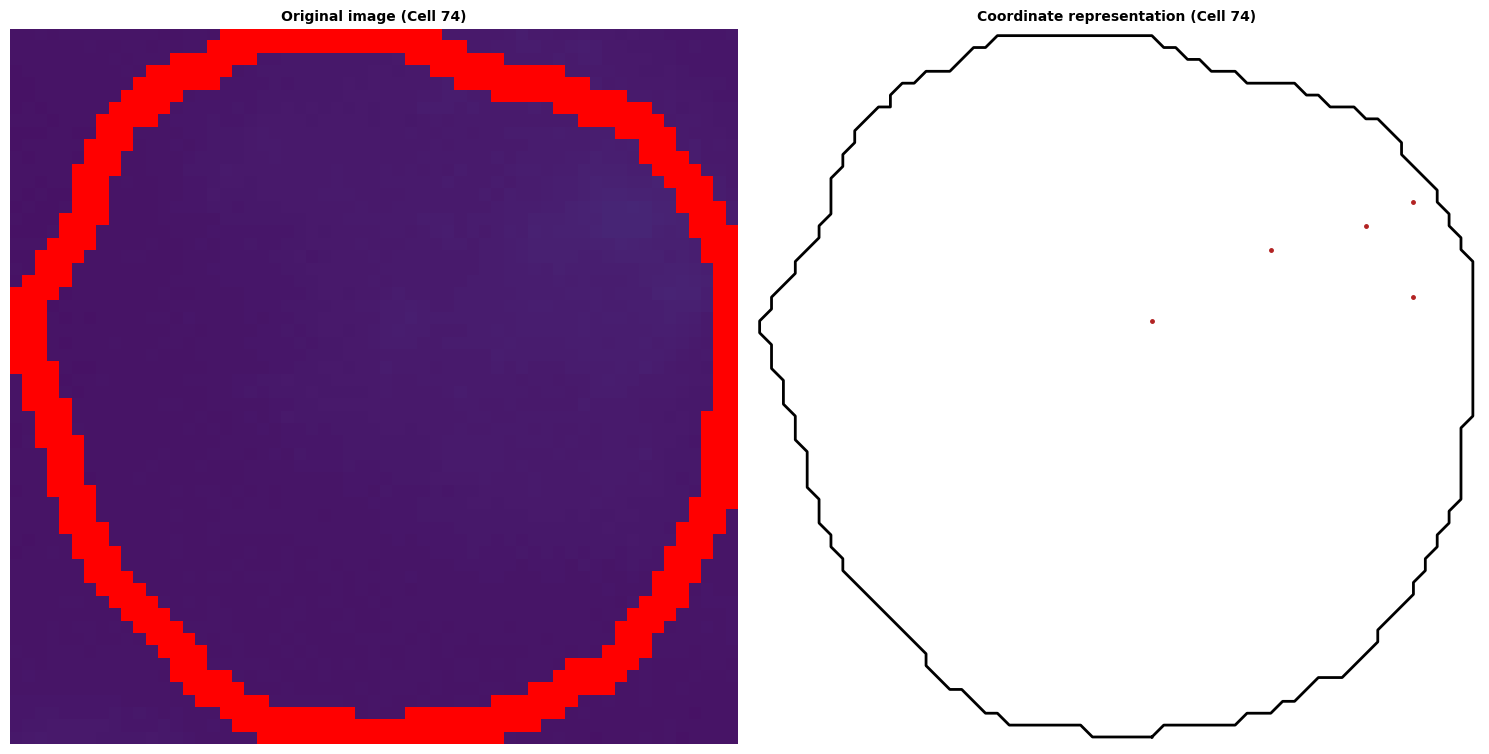

cell 75, mother
 number of rna 1


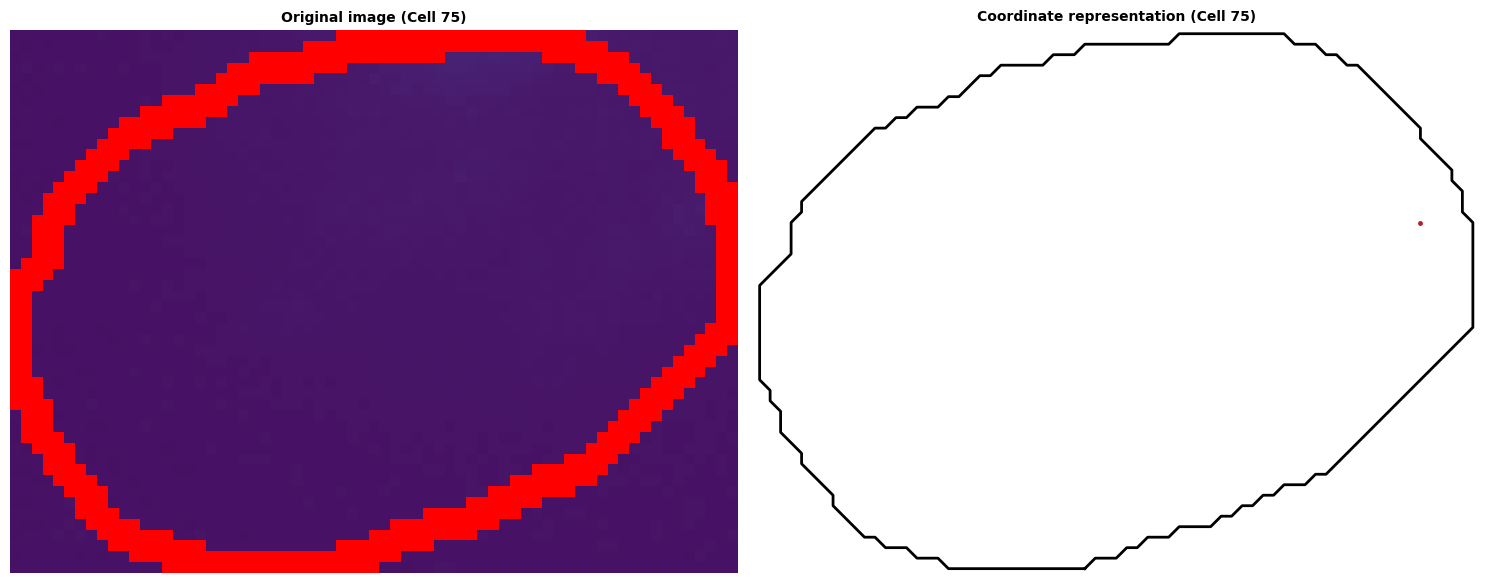

cell 76, bud
 number of rna 0


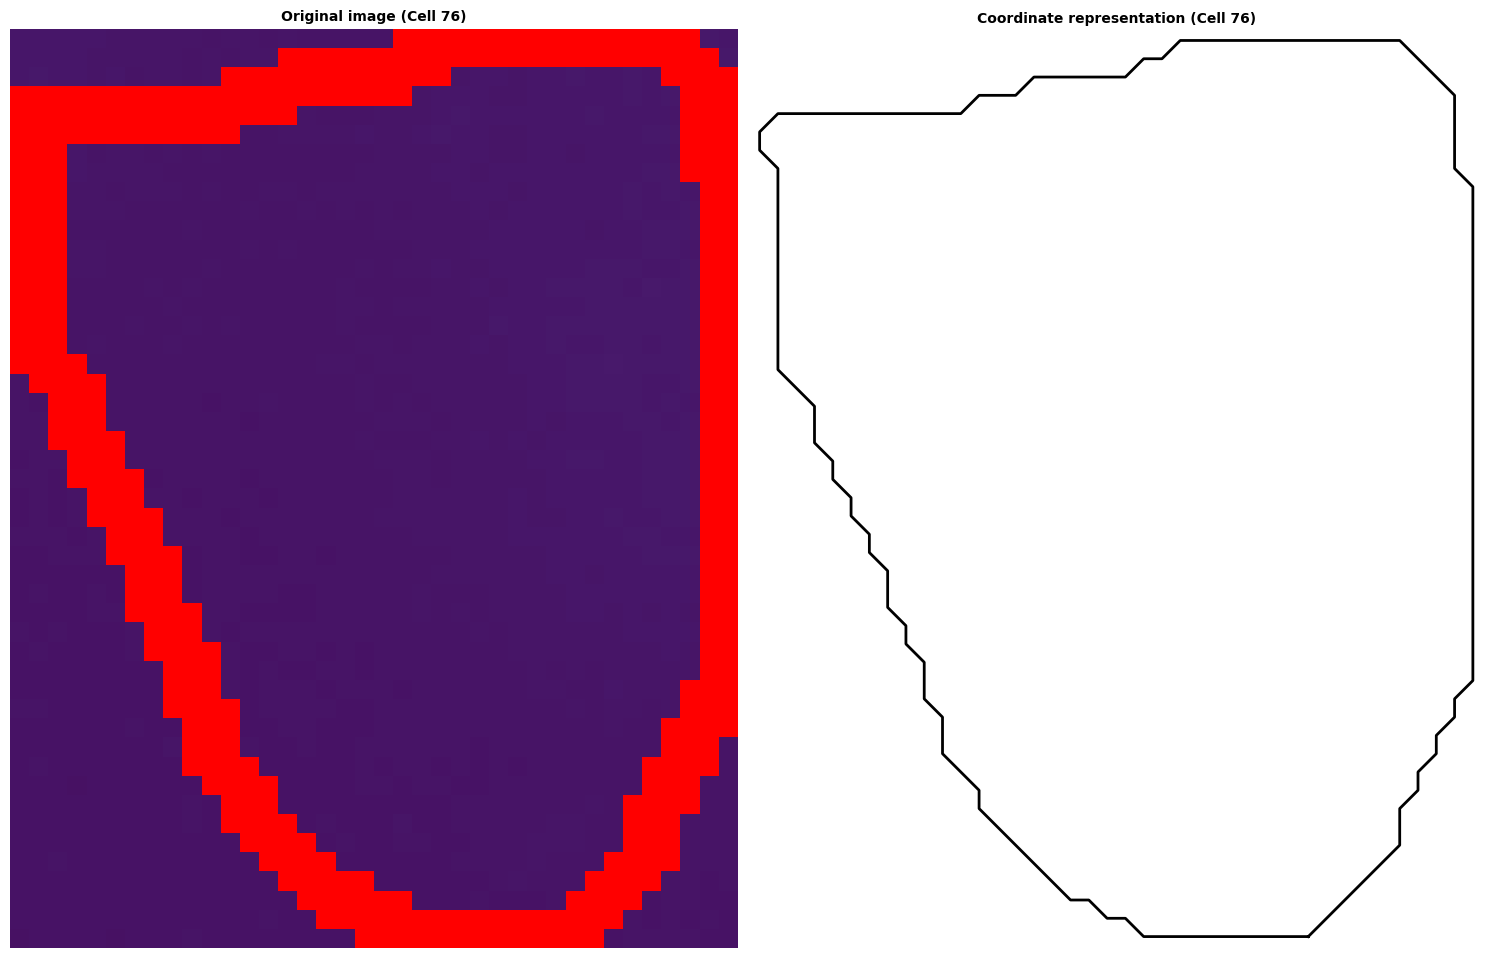

cell 79, bud
 number of rna 0


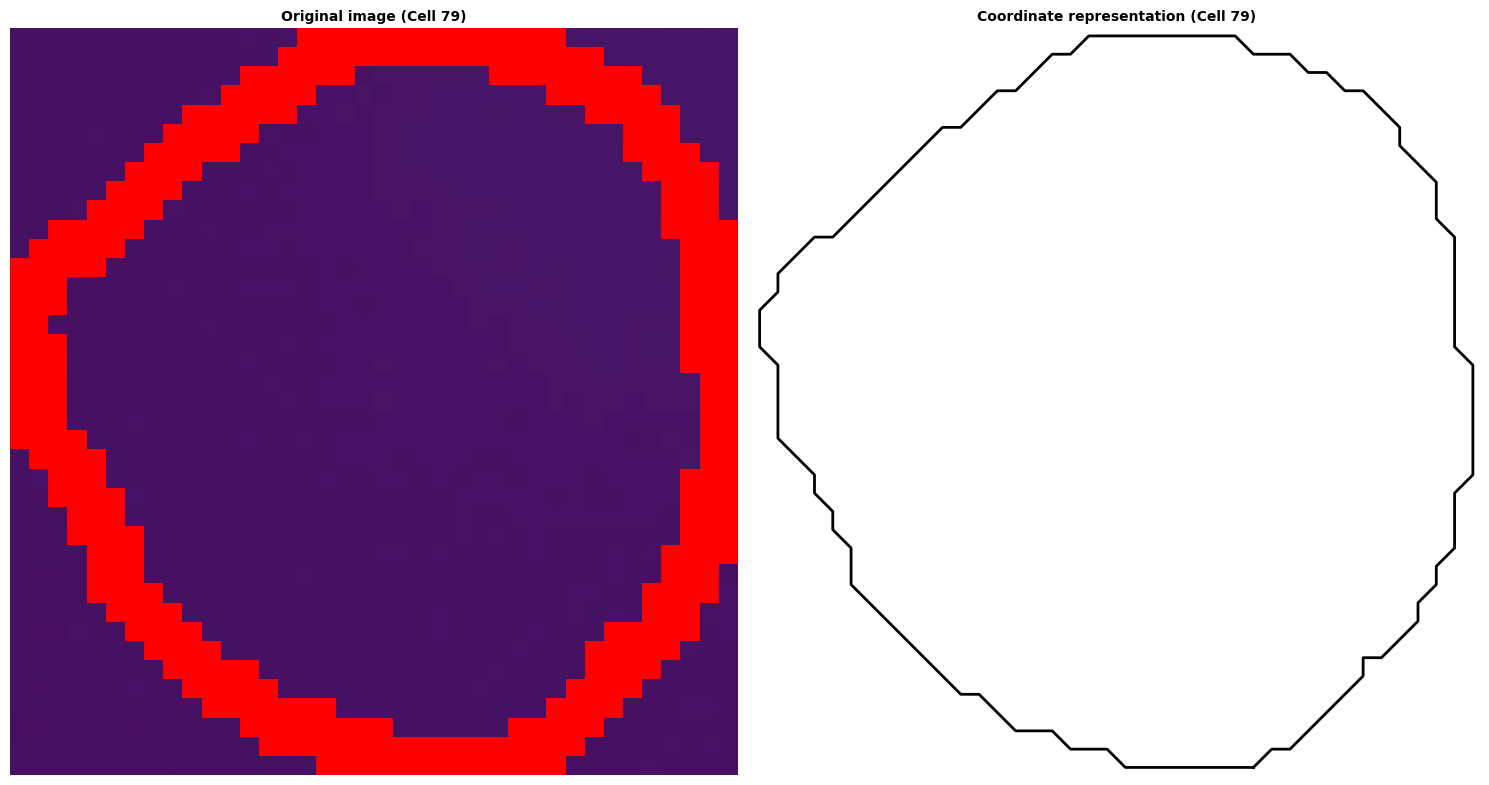

cell 80, mother
 number of rna 4


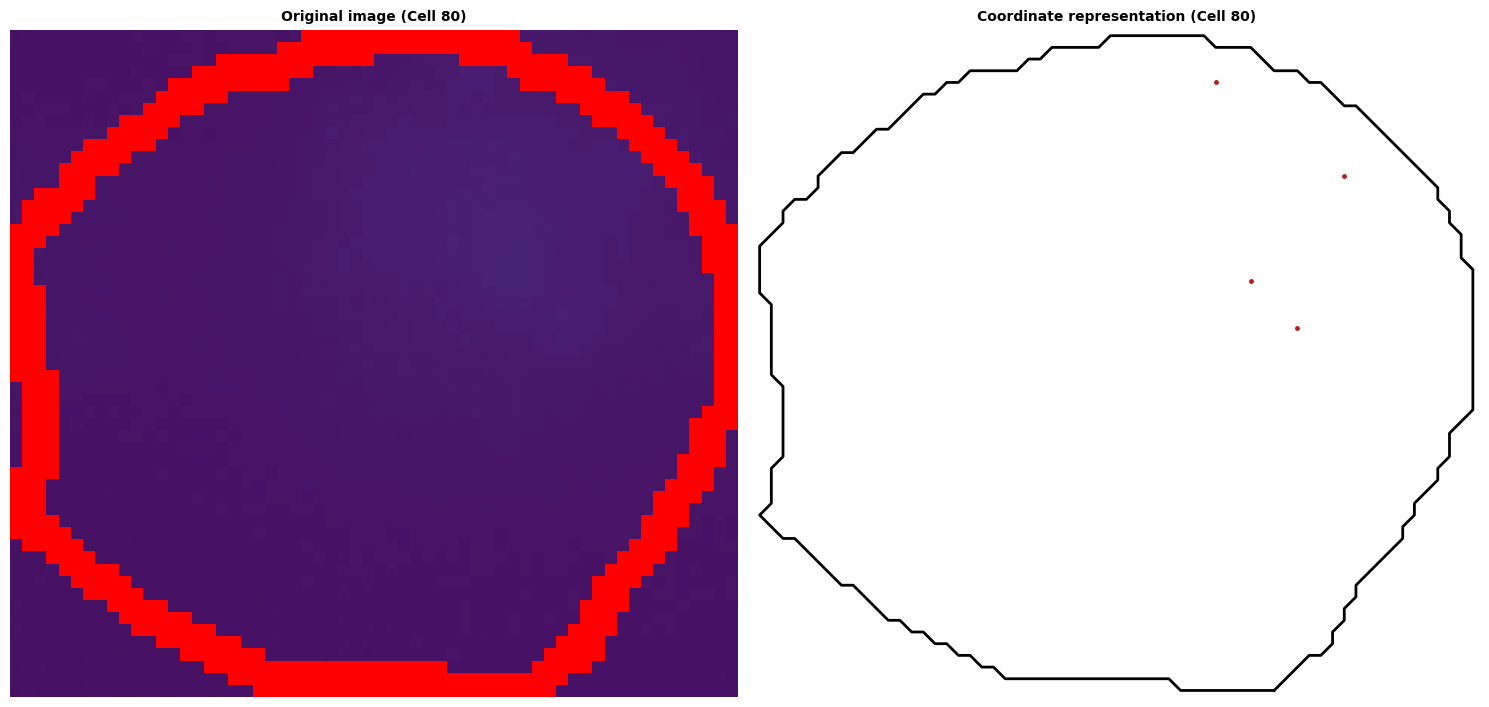

cell 81, mother
 number of rna 2


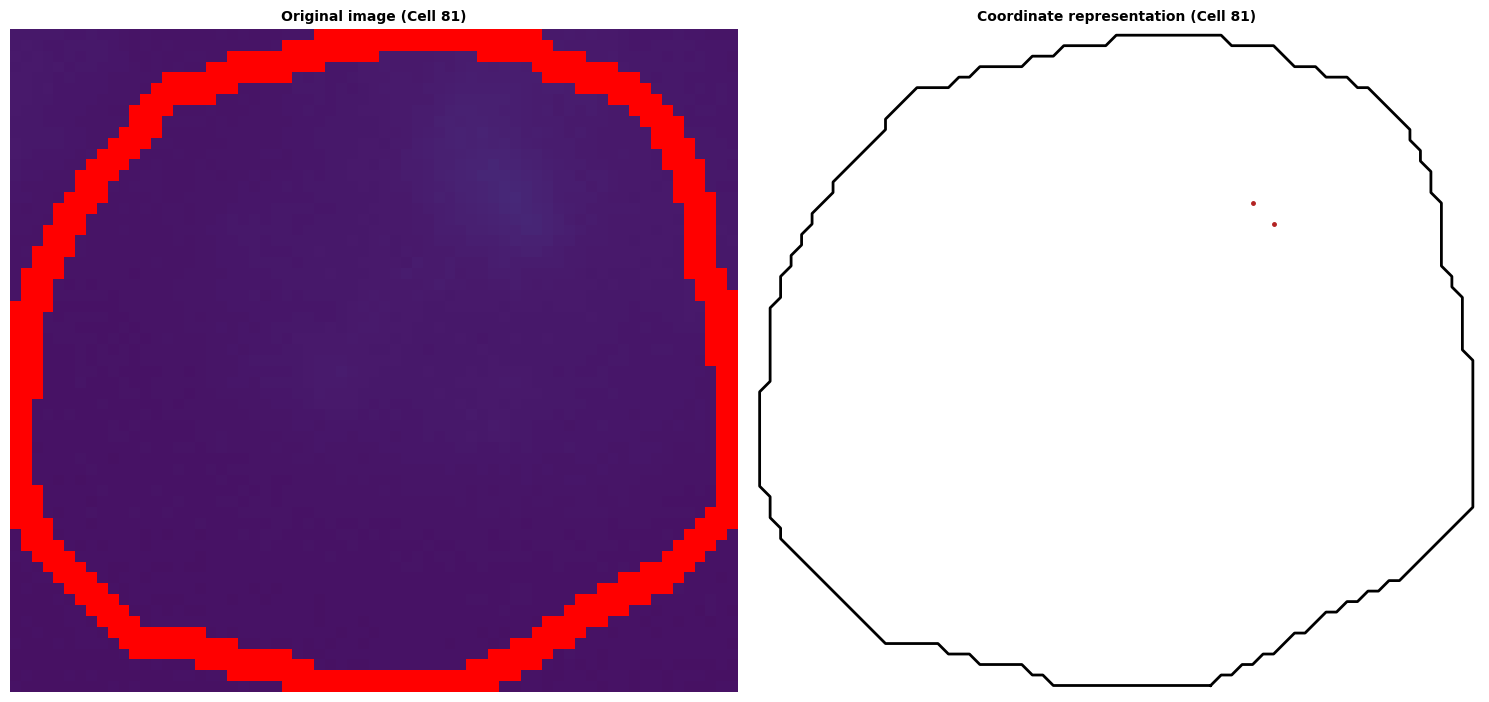

cell 82, bud
 number of rna 1


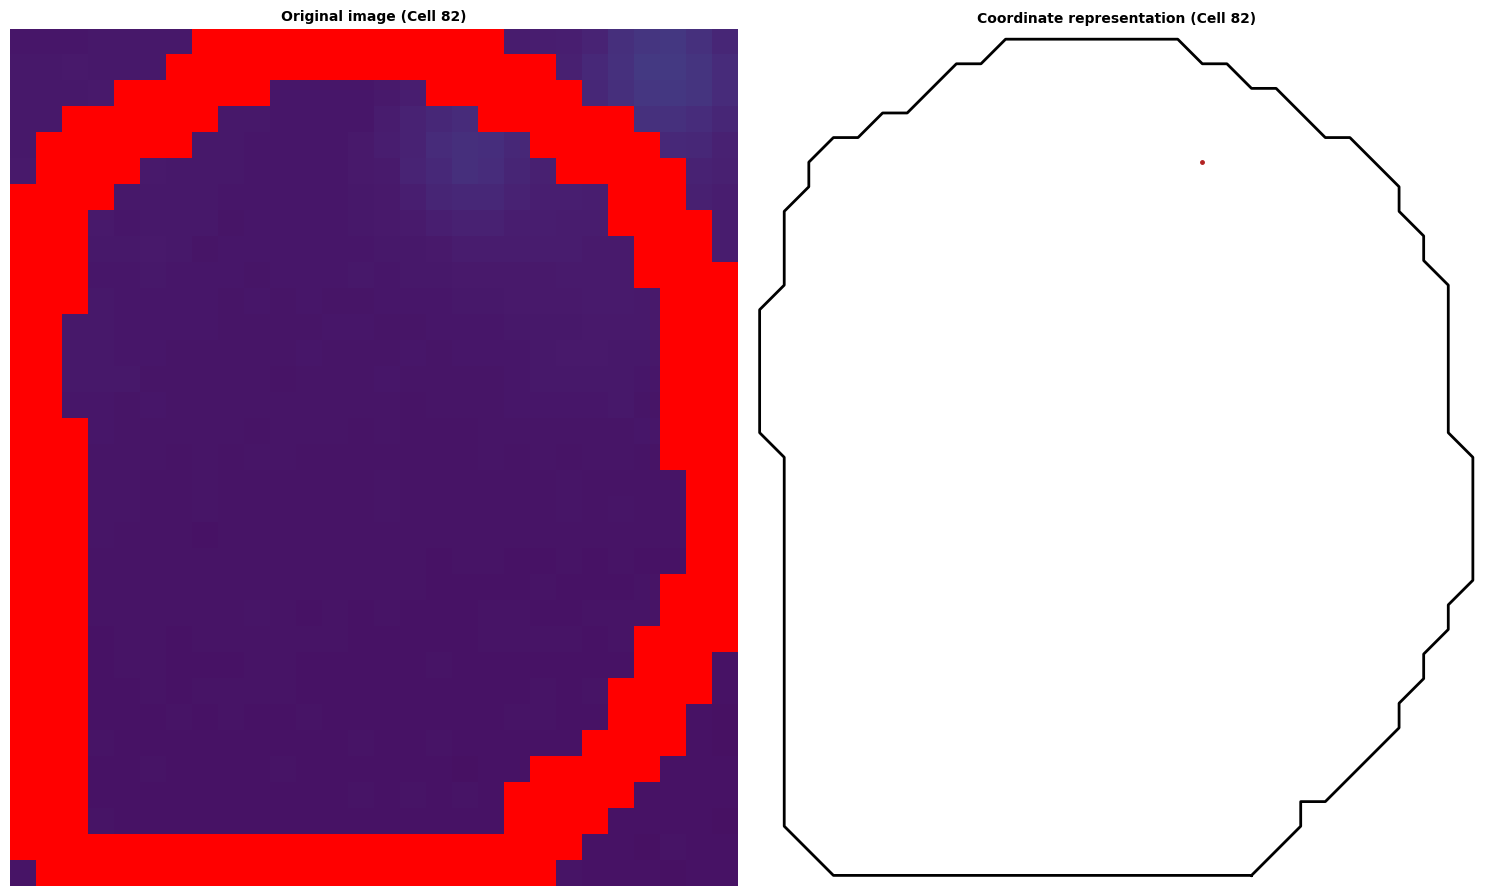

cell 77, bud
 number of rna 0


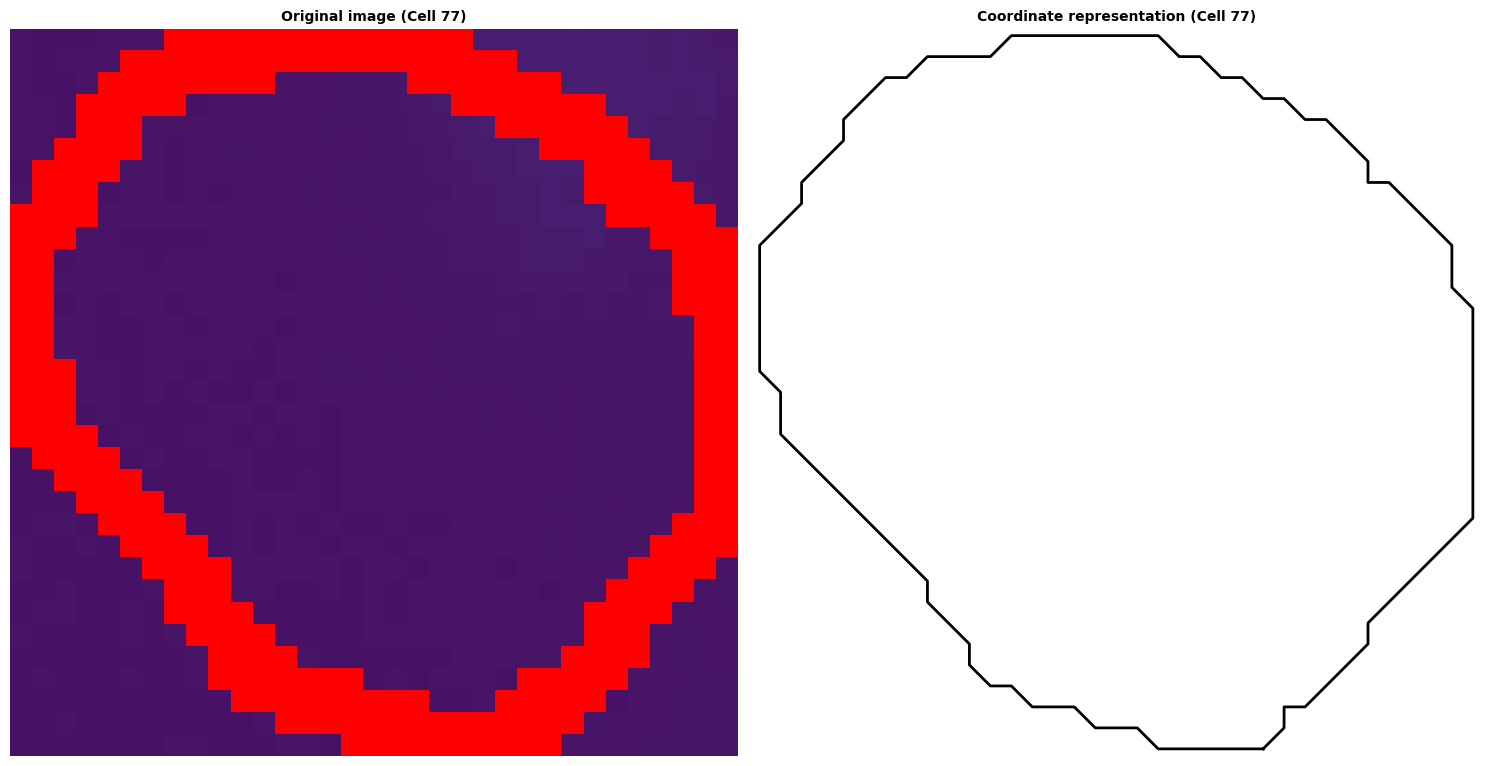

cell 78, mother
 number of rna 6


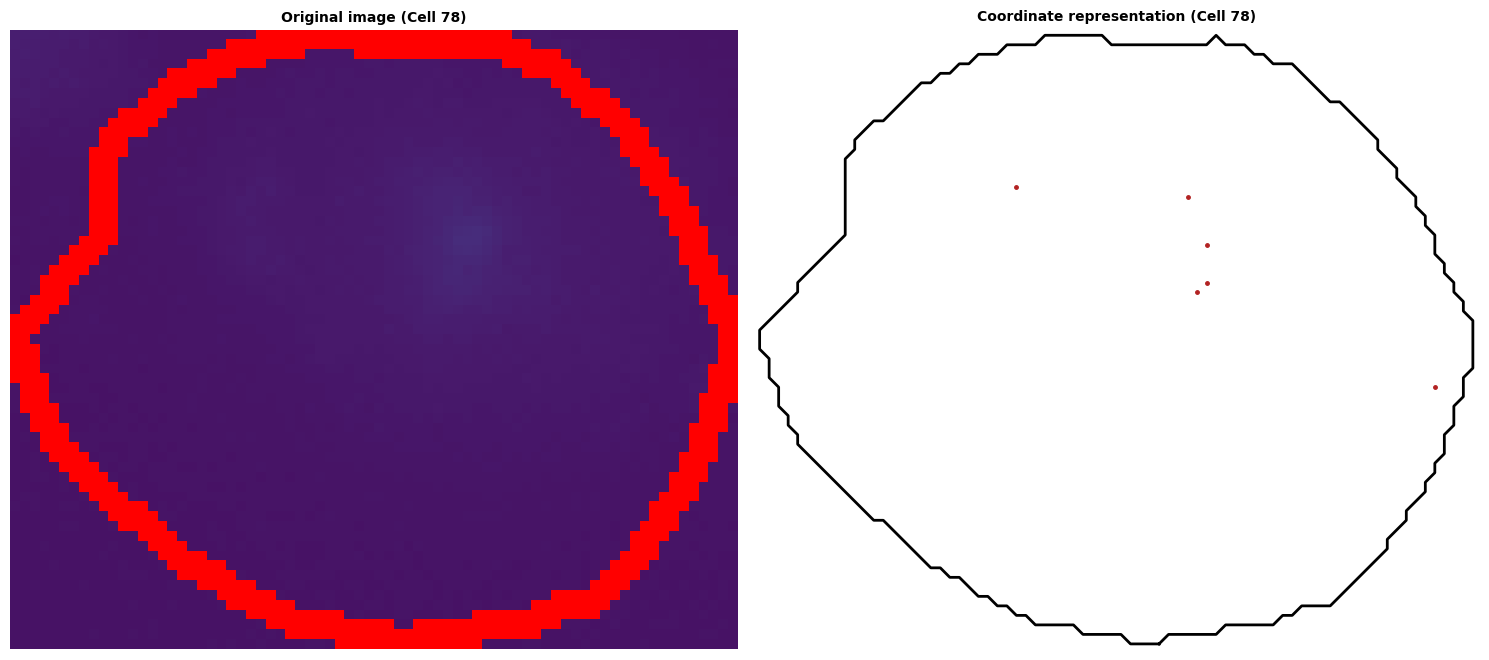

cell 95, bud
 number of rna 0


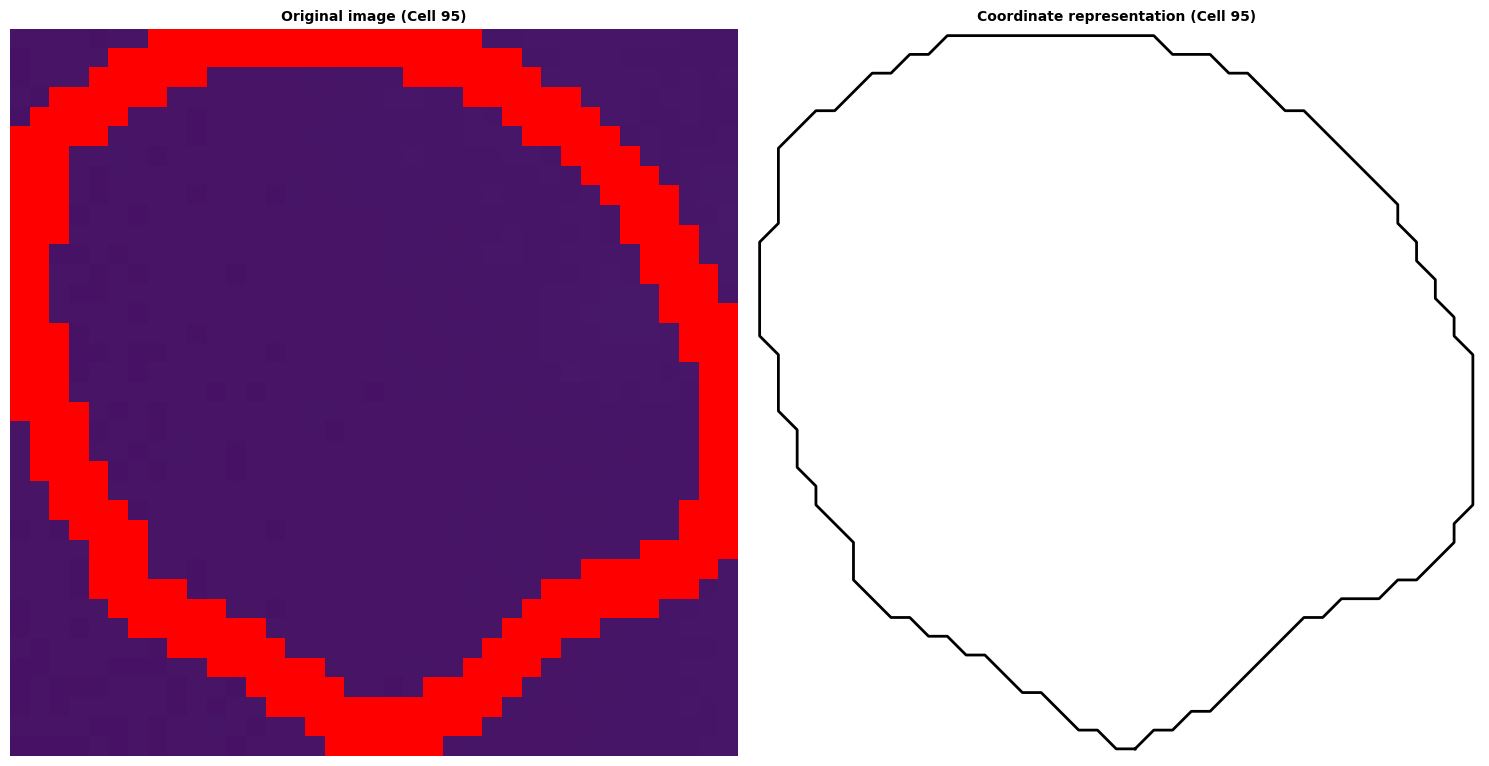

cell 96, mother
 number of rna 6


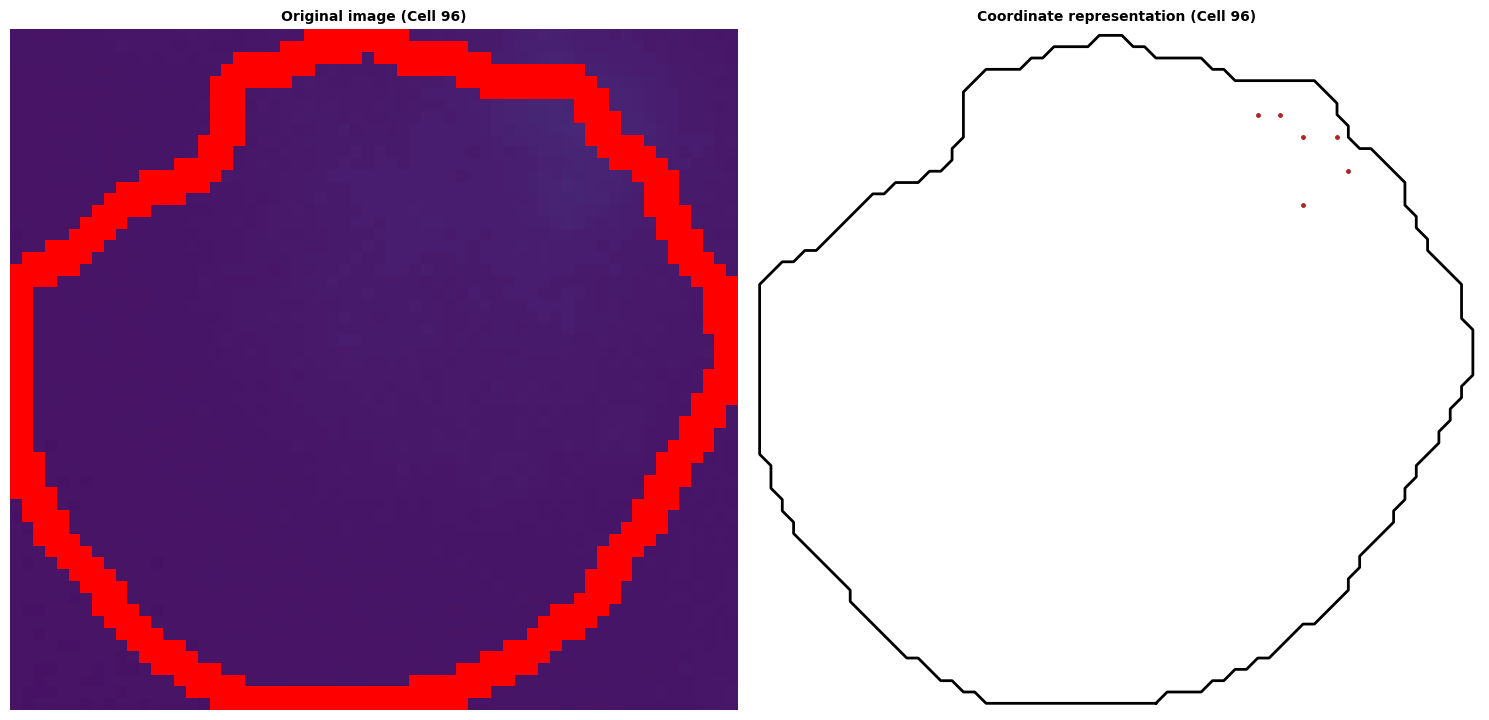

cell 99, mother
 number of rna 5


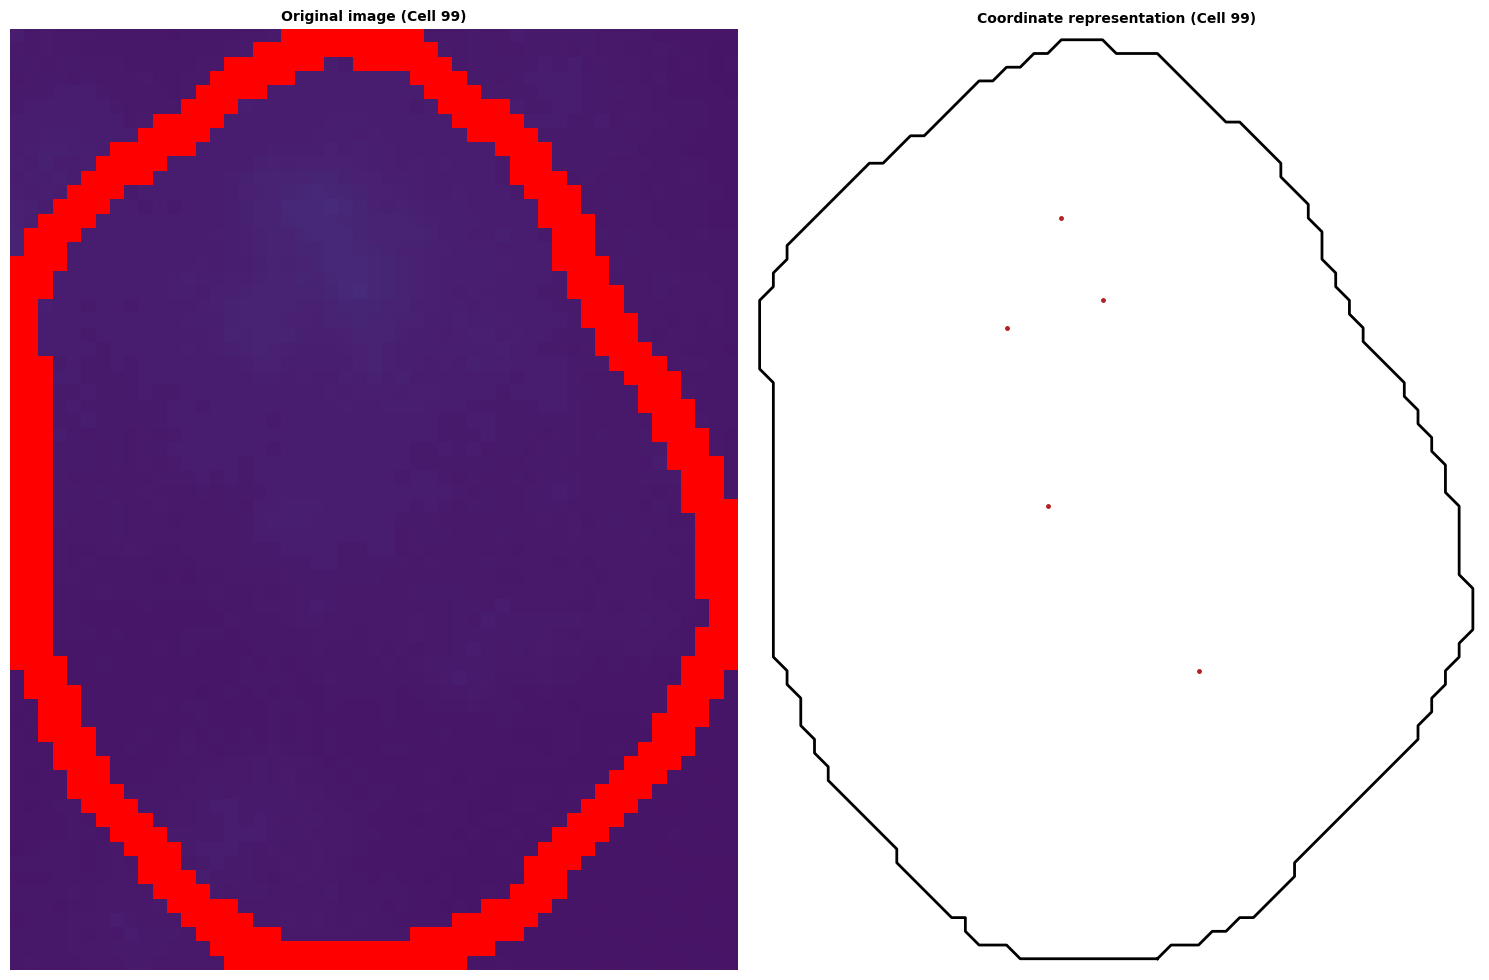

cell 100, bud
 number of rna 1


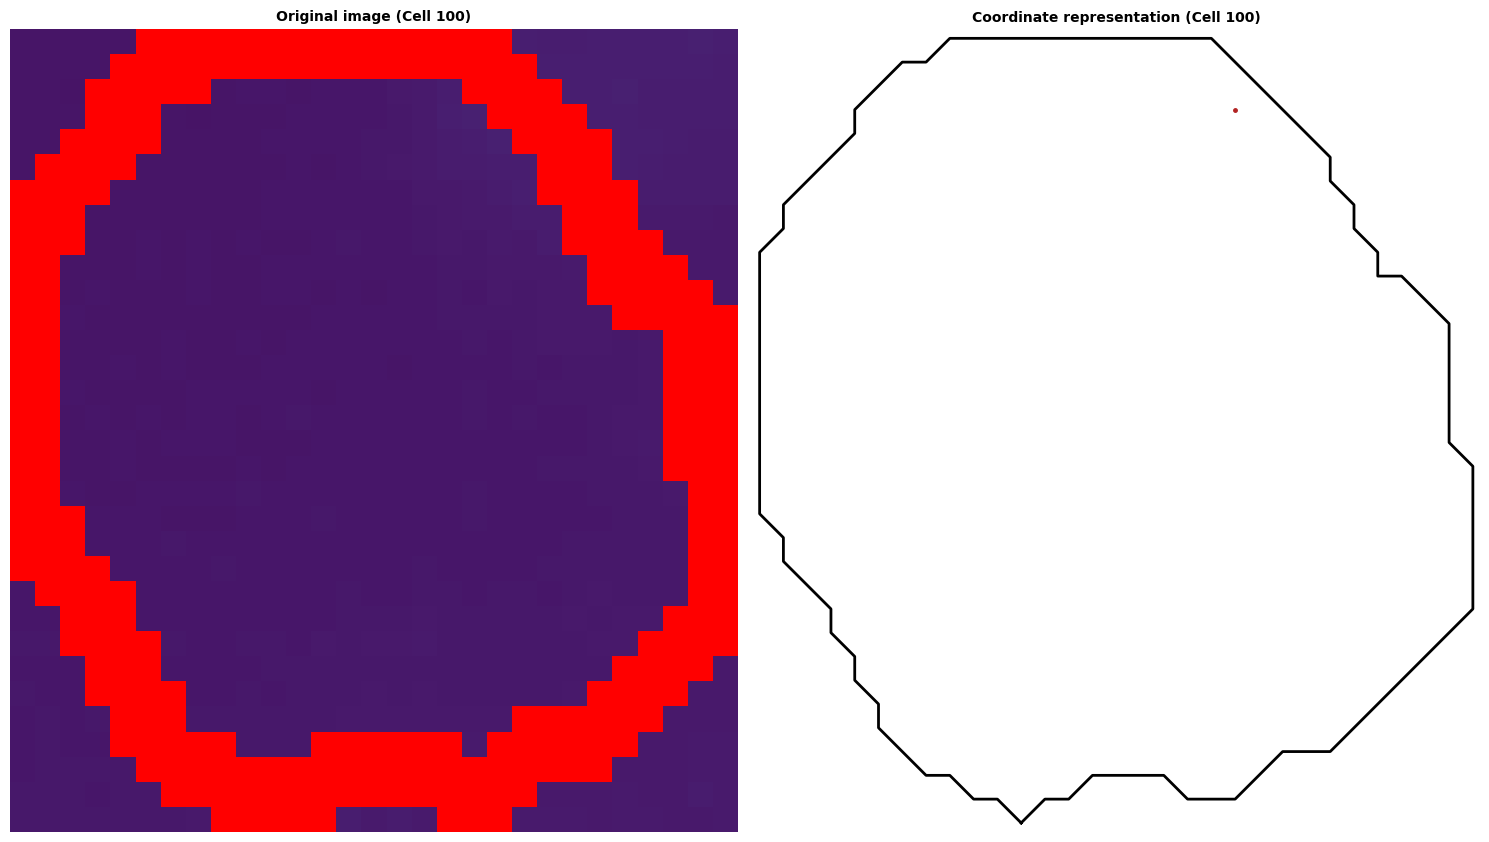

cell 87, bud
 number of rna 2


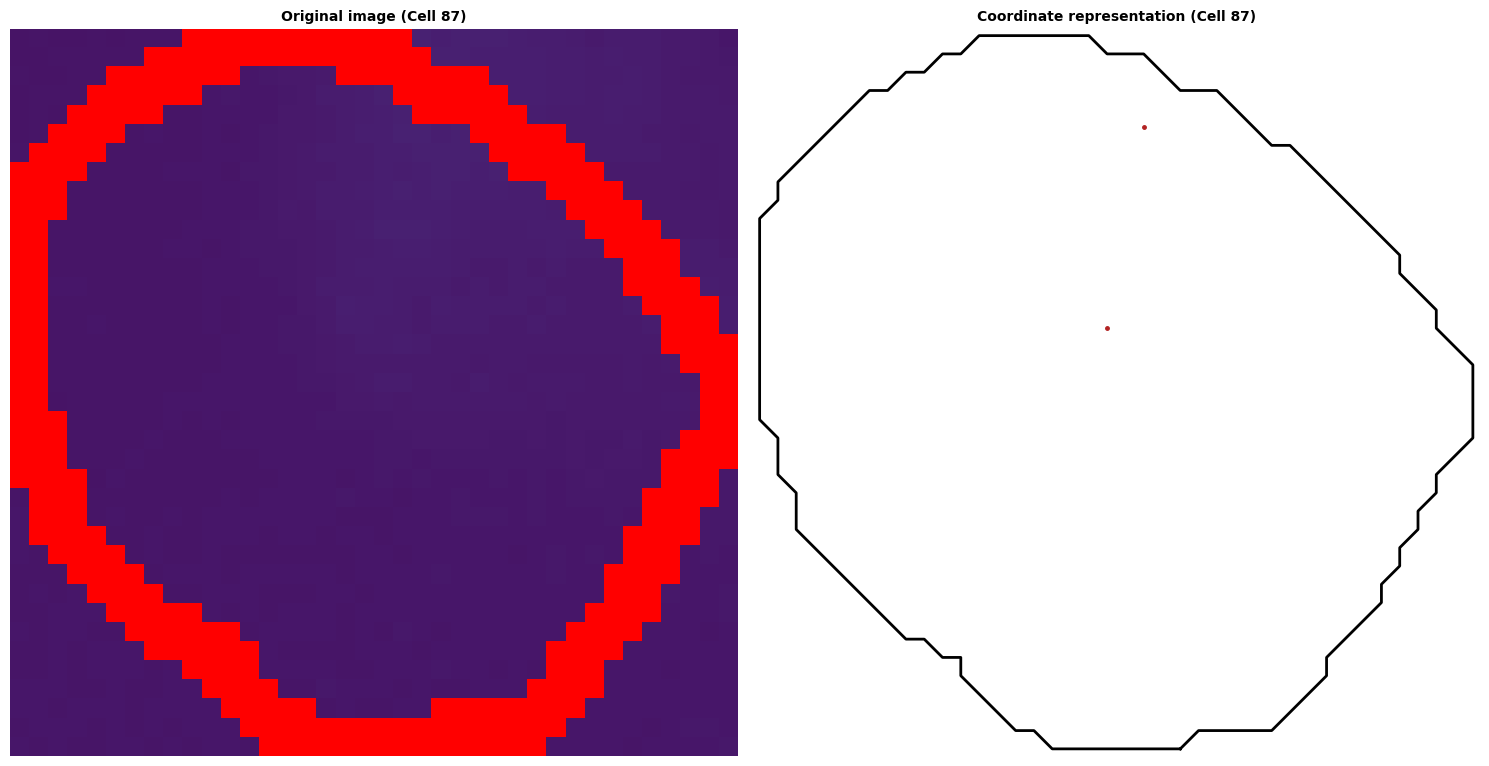

cell 88, mother
 number of rna 4


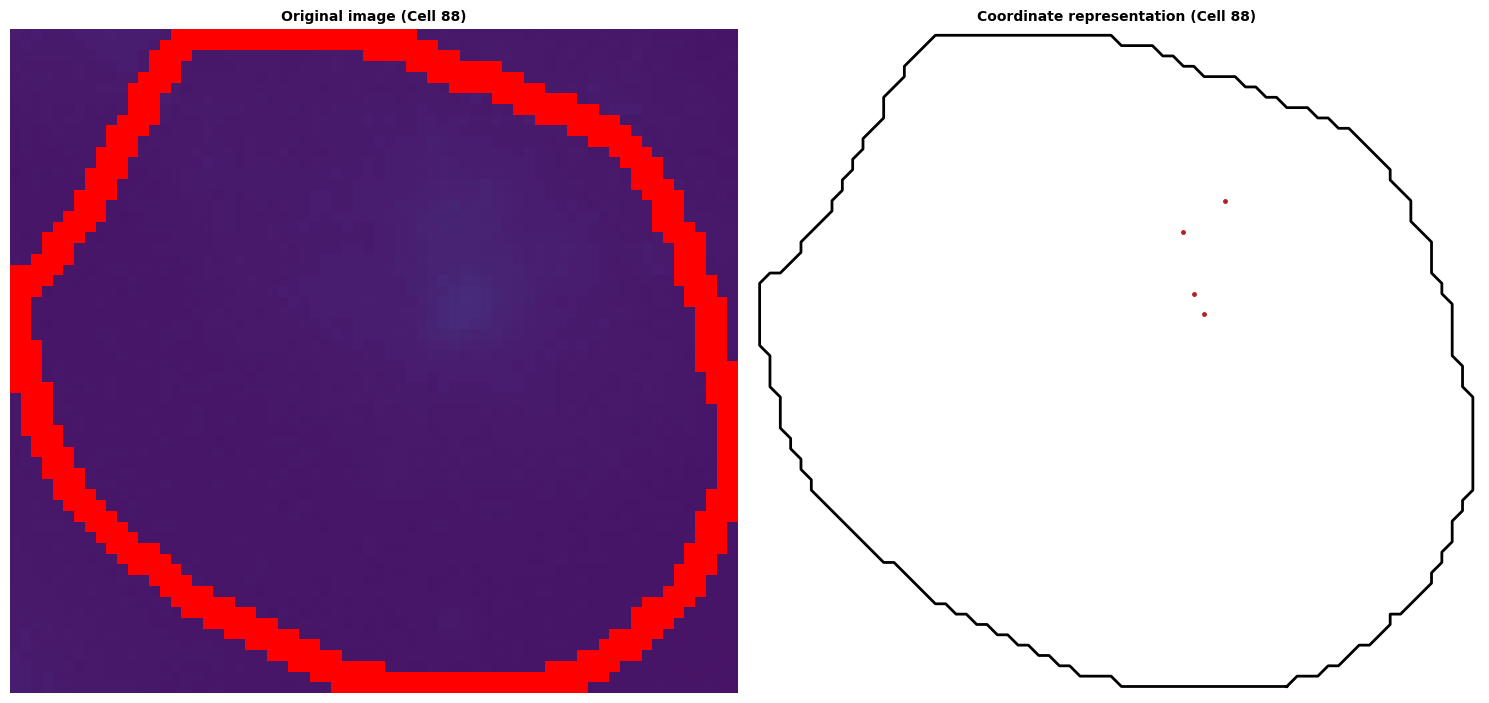

cell 93, bud
 number of rna 0


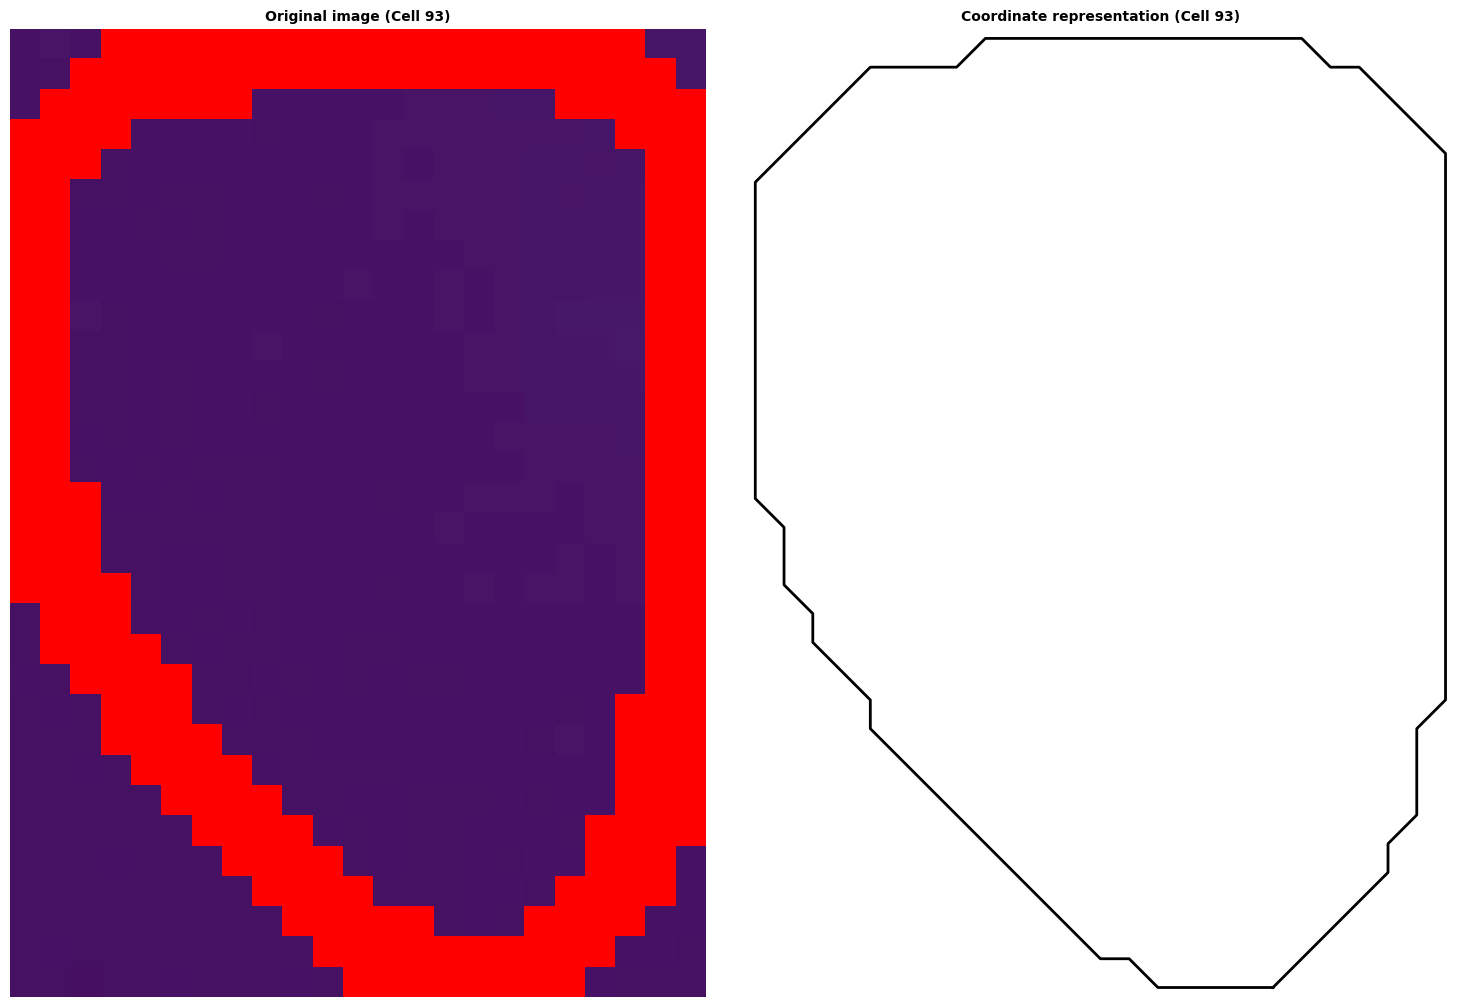

cell 94, mother
 number of rna 1


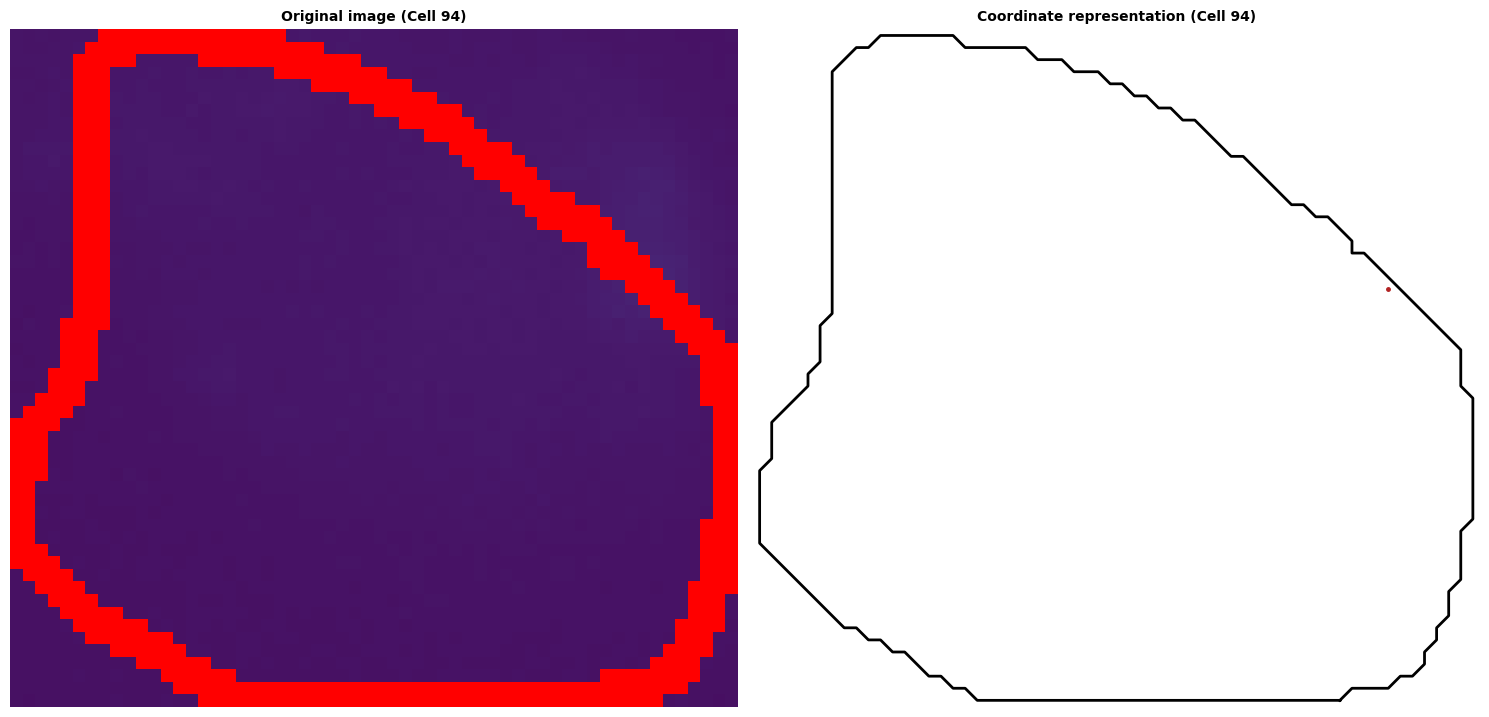

cell 89, bud
 number of rna 0


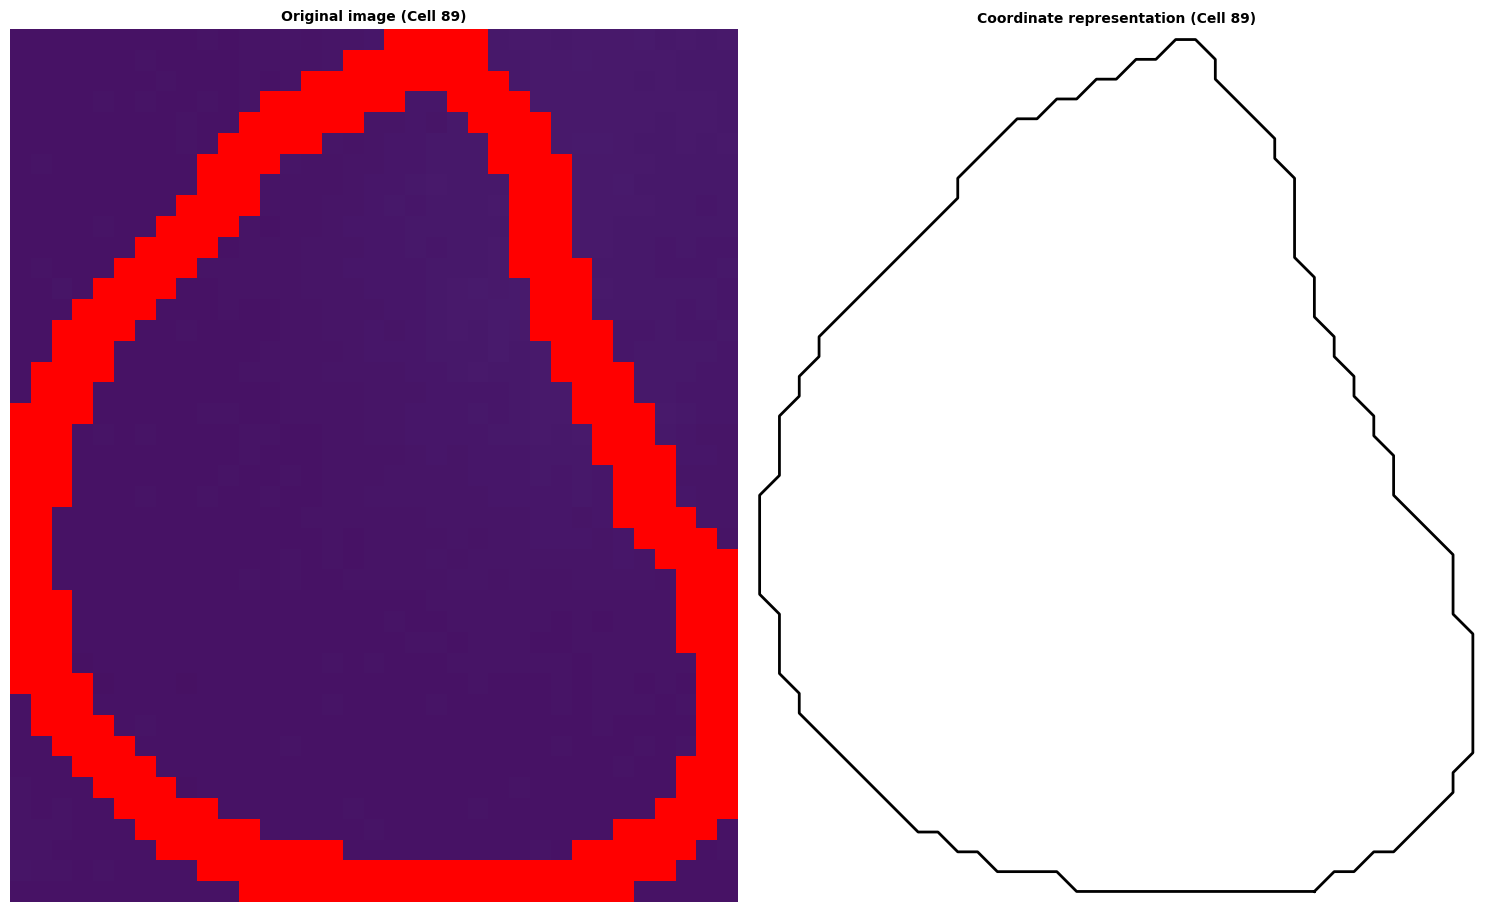

cell 90, mother
 number of rna 4


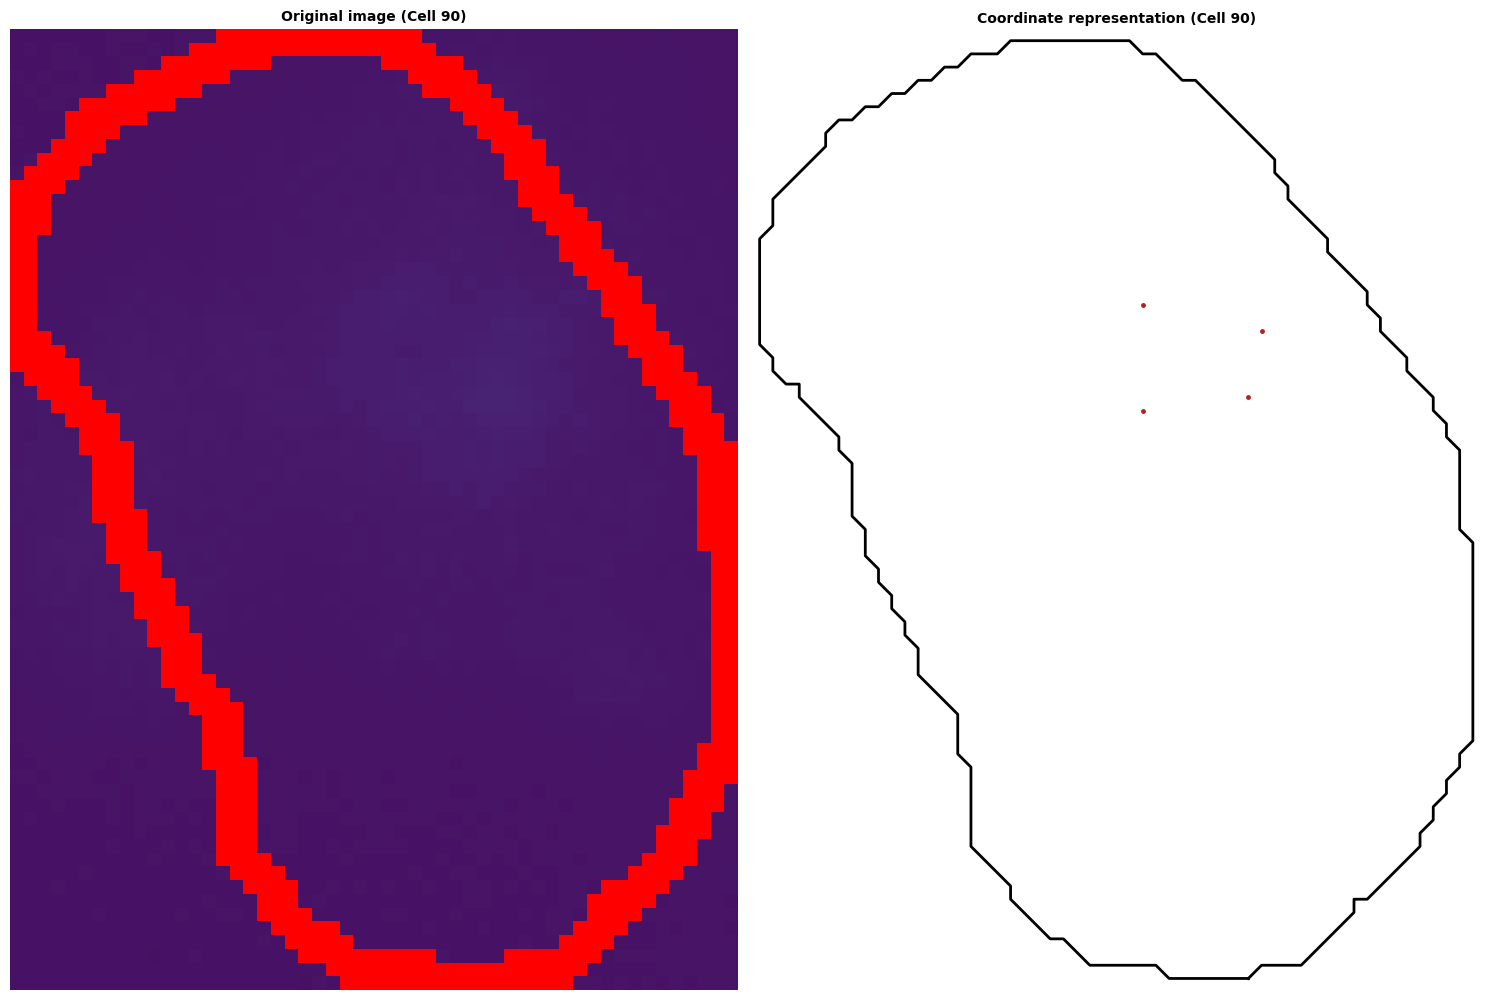

cell 83, bud
 number of rna 0


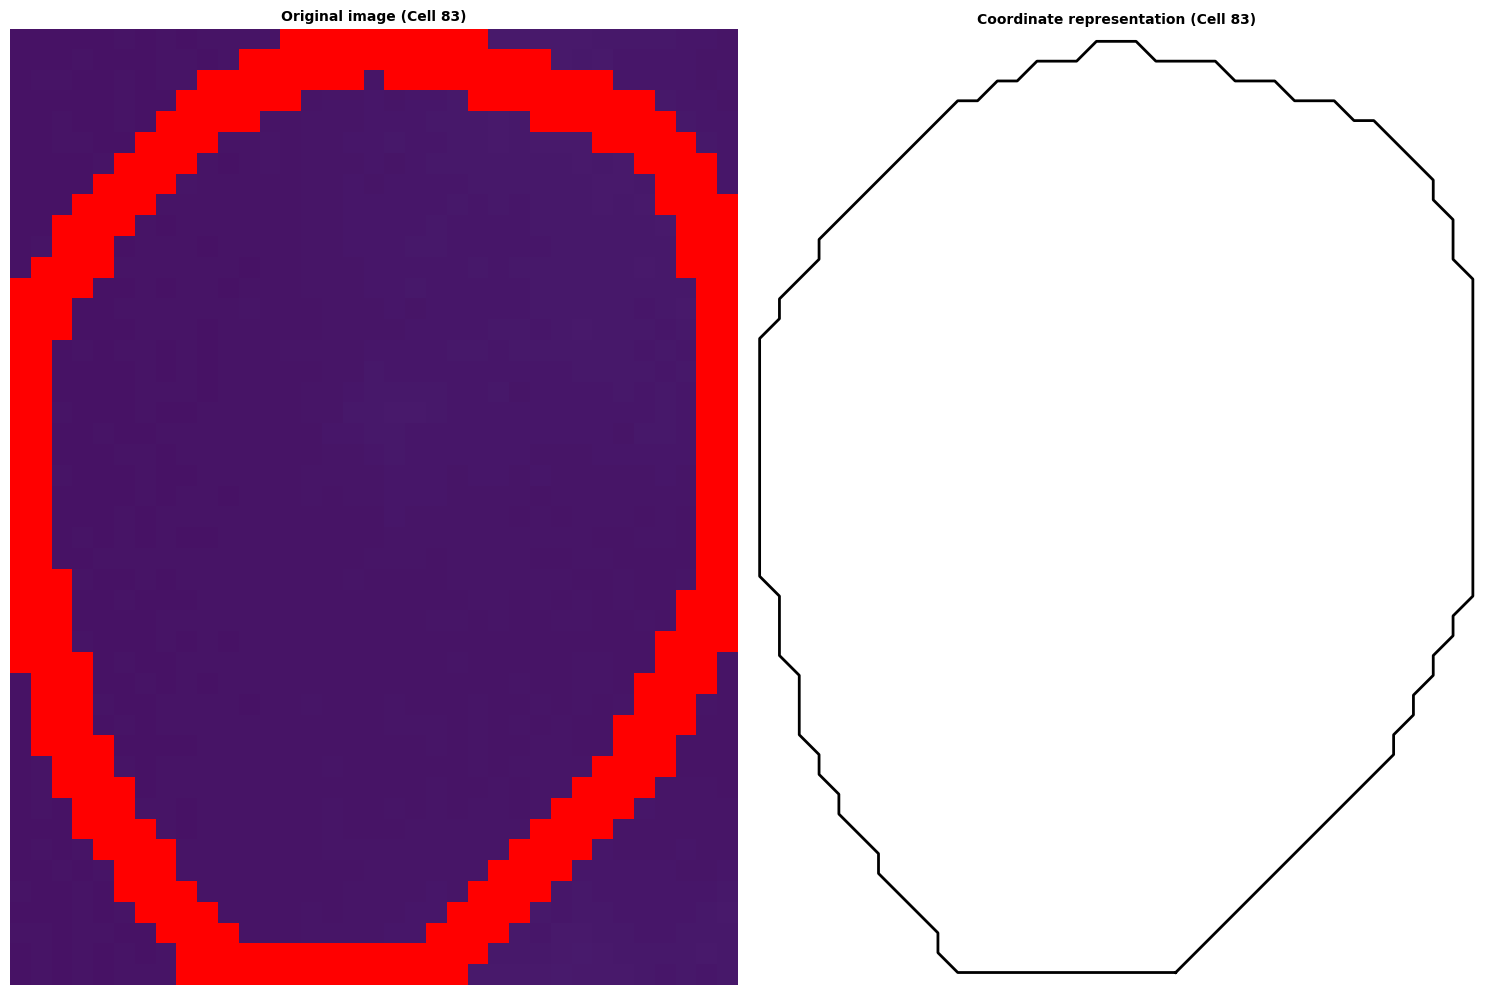

cell 84, mother
 number of rna 3


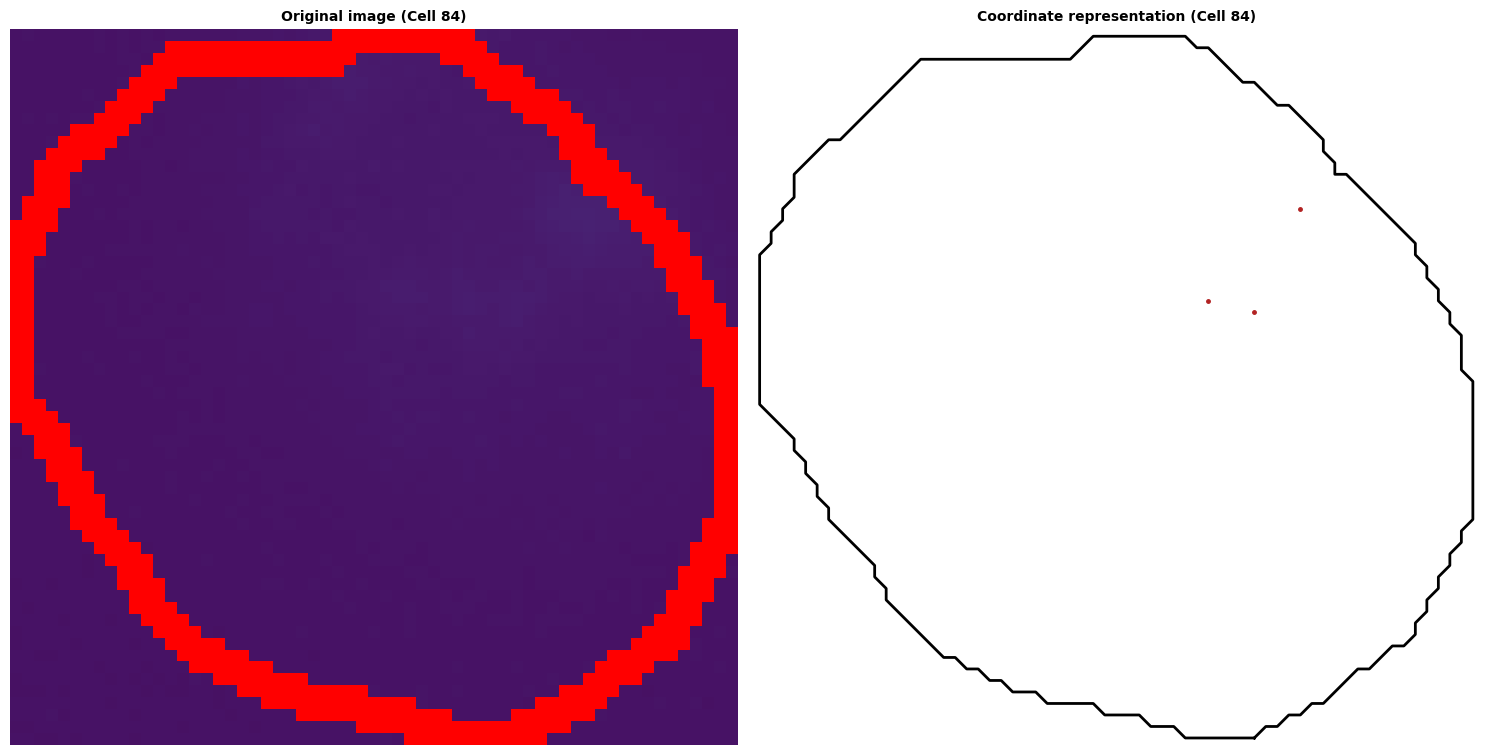

cell 85, mother
 number of rna 1


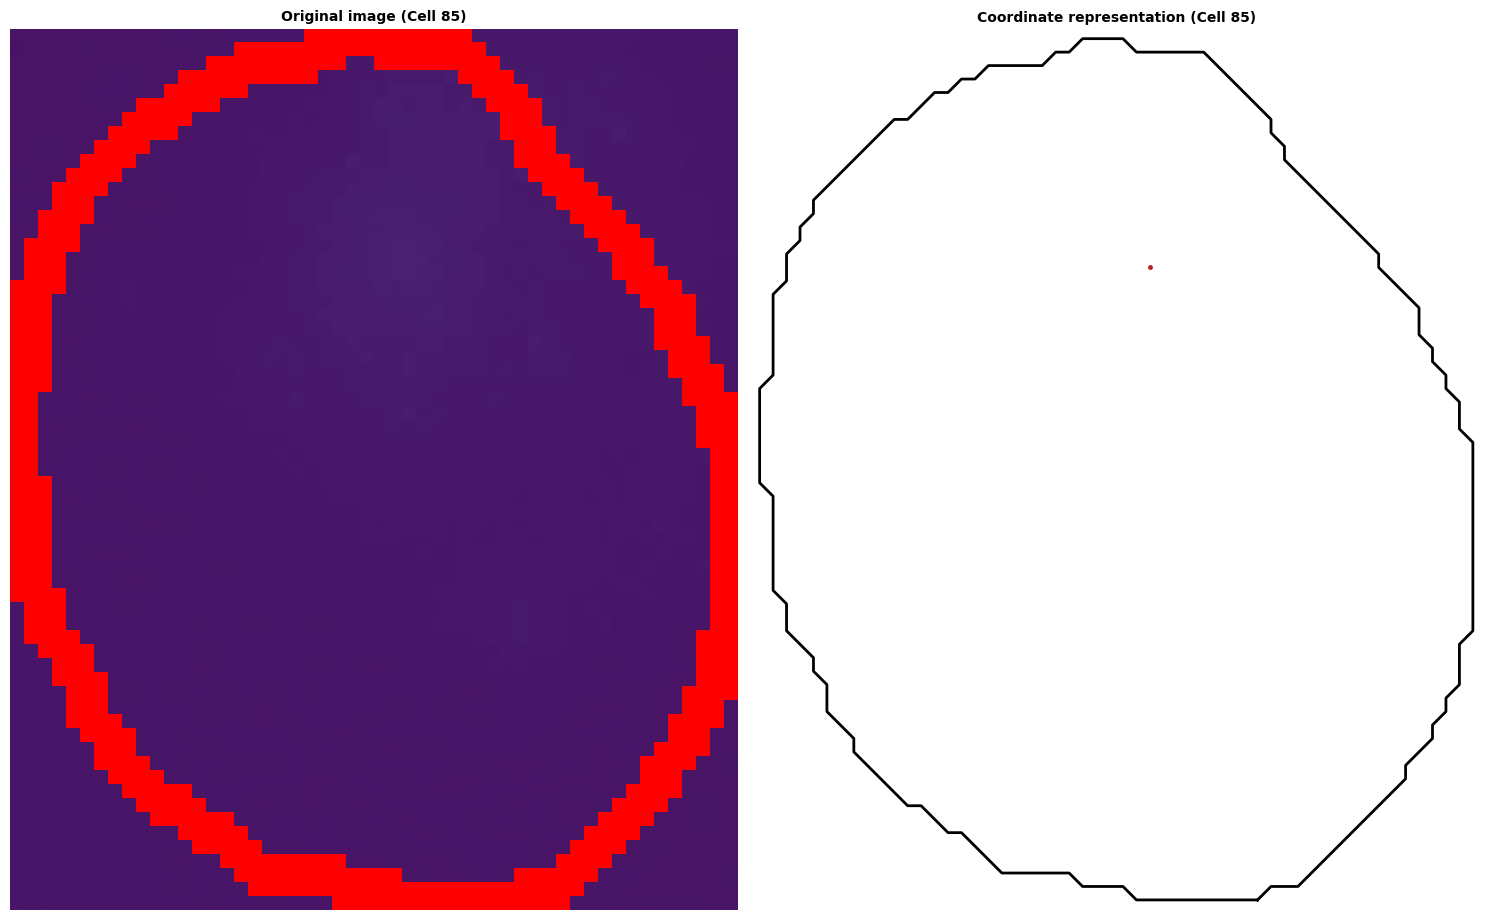

cell 86, bud
 number of rna 0


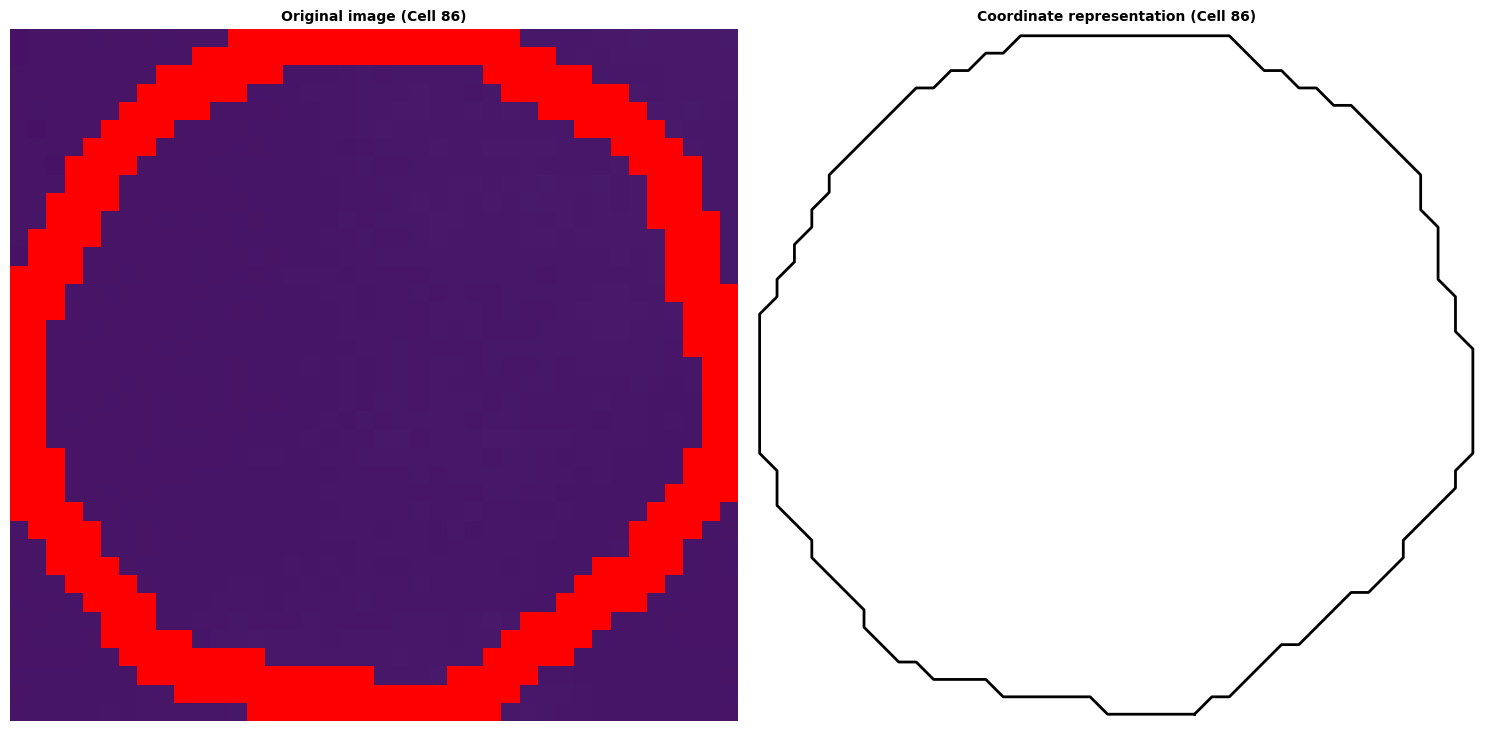

cell 91, mother
 number of rna 6


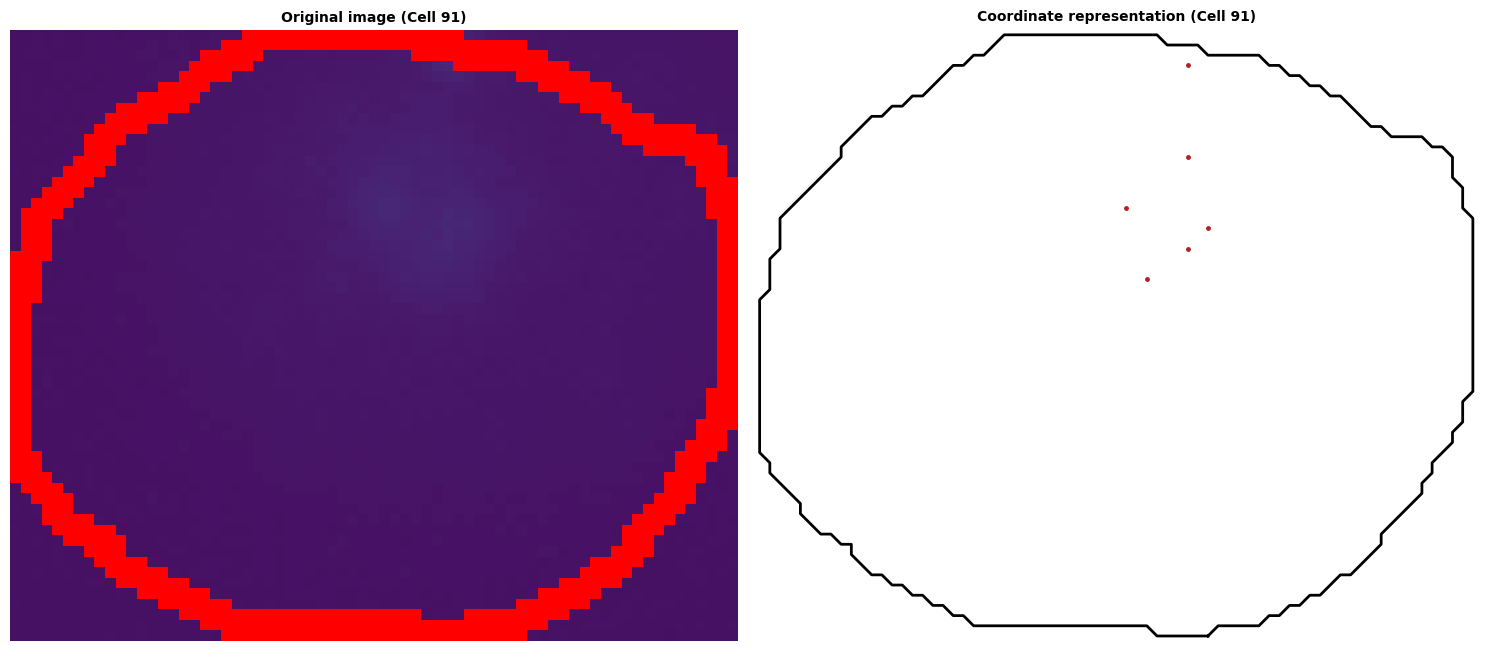

cell 92, bud
 number of rna 0


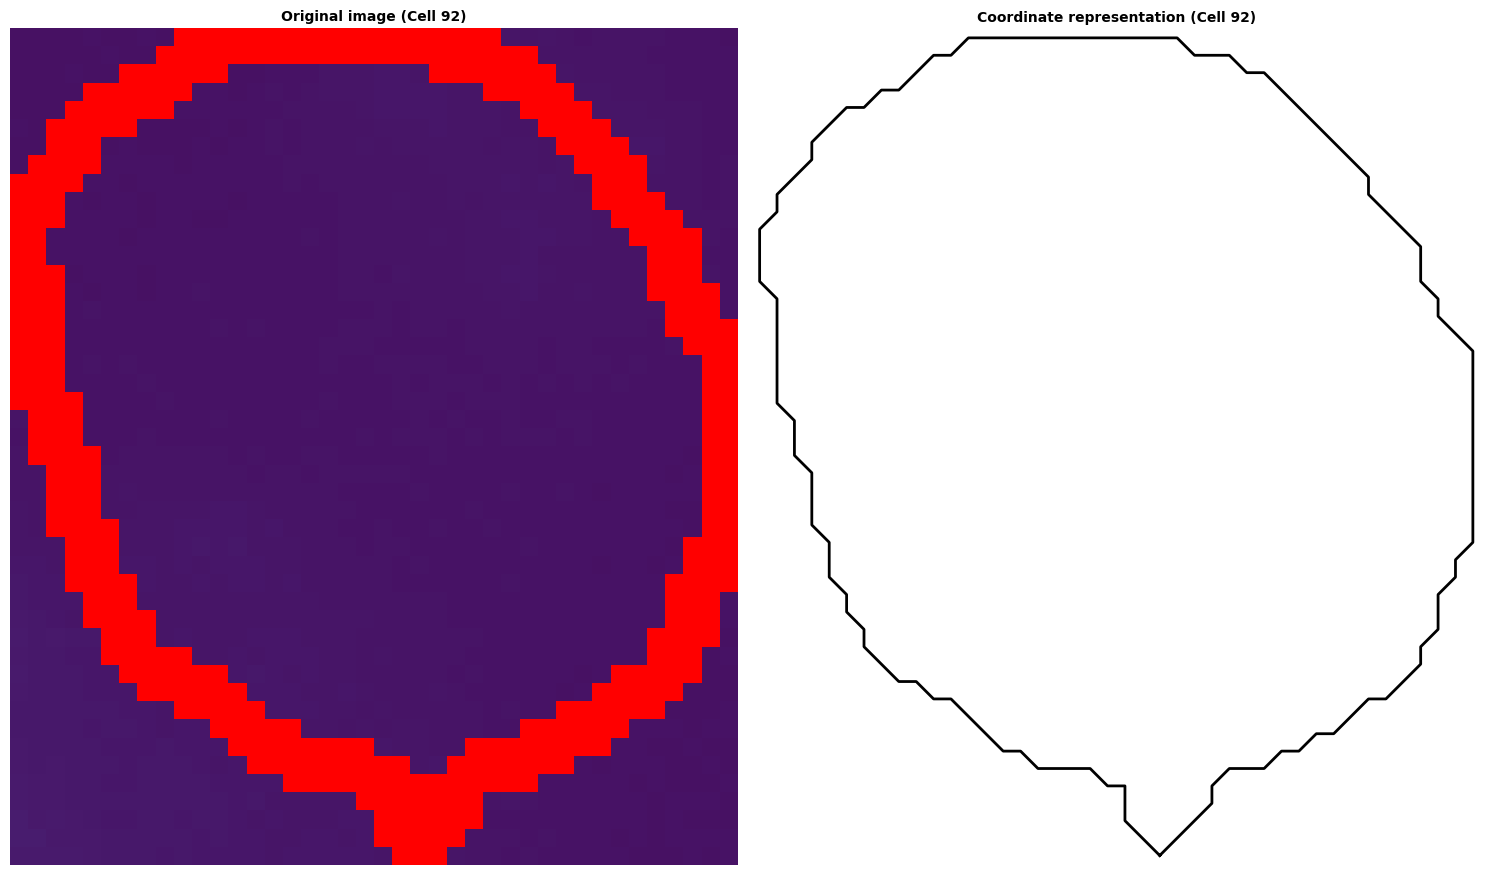

cell 97, mother
 number of rna 2


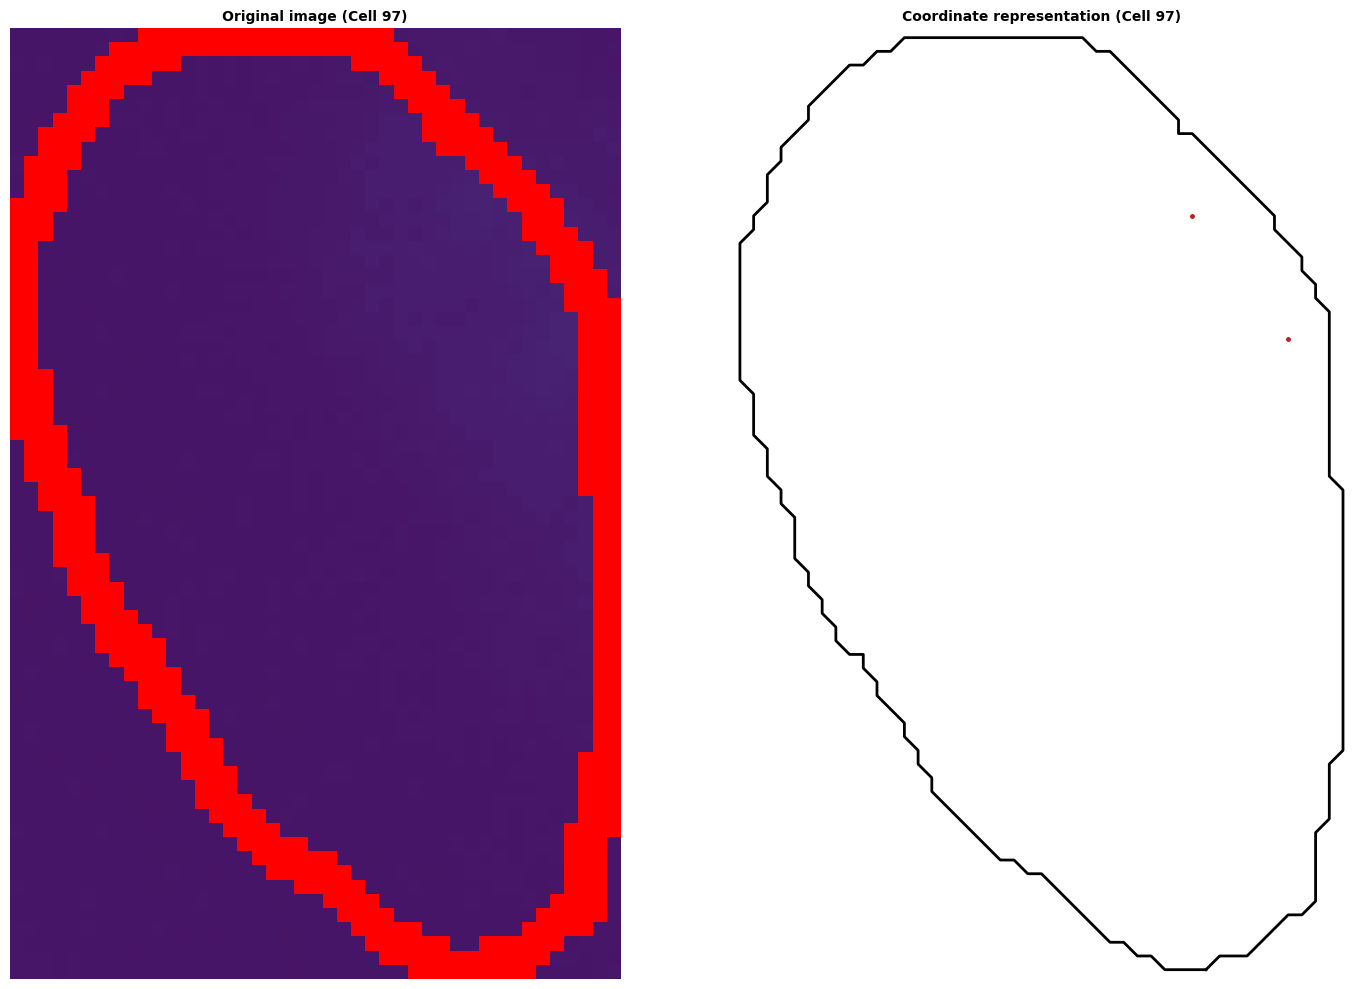

cell 98, bud
 number of rna 2


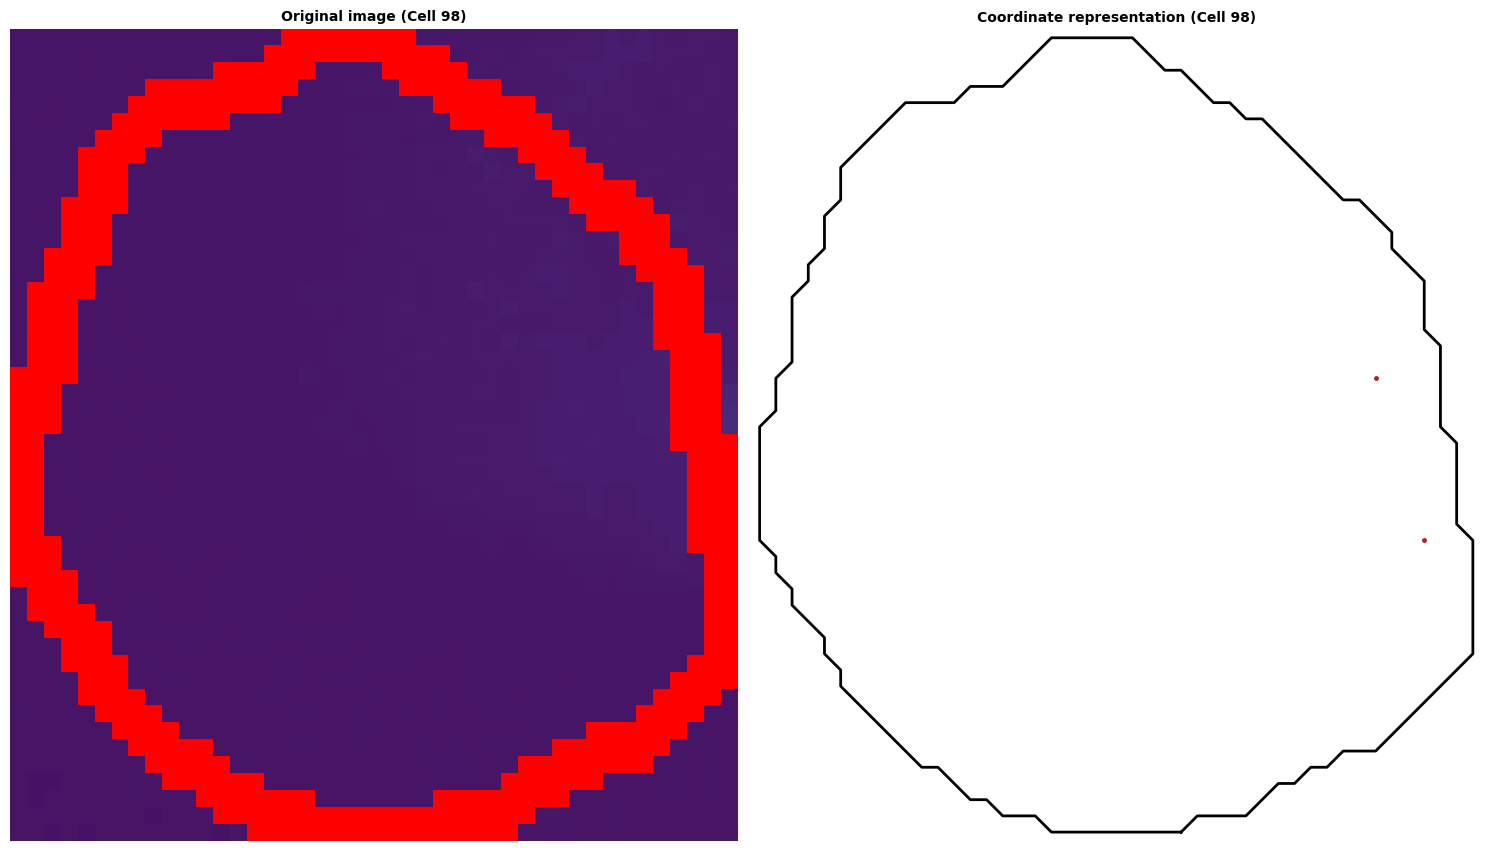

cell 101, bud
 number of rna 0


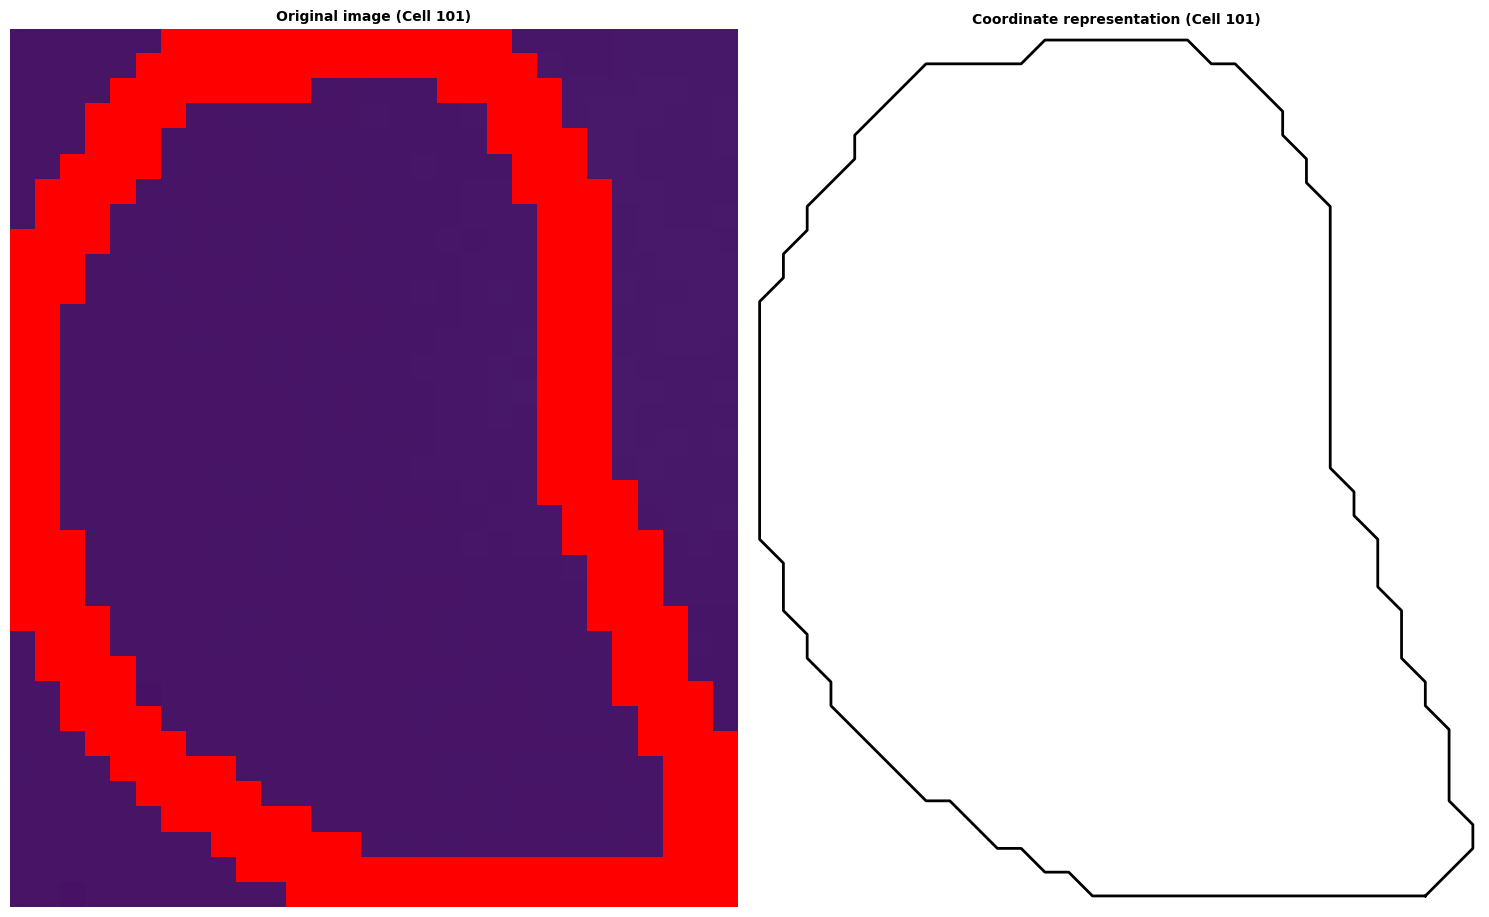

cell 102, mother
 number of rna 5


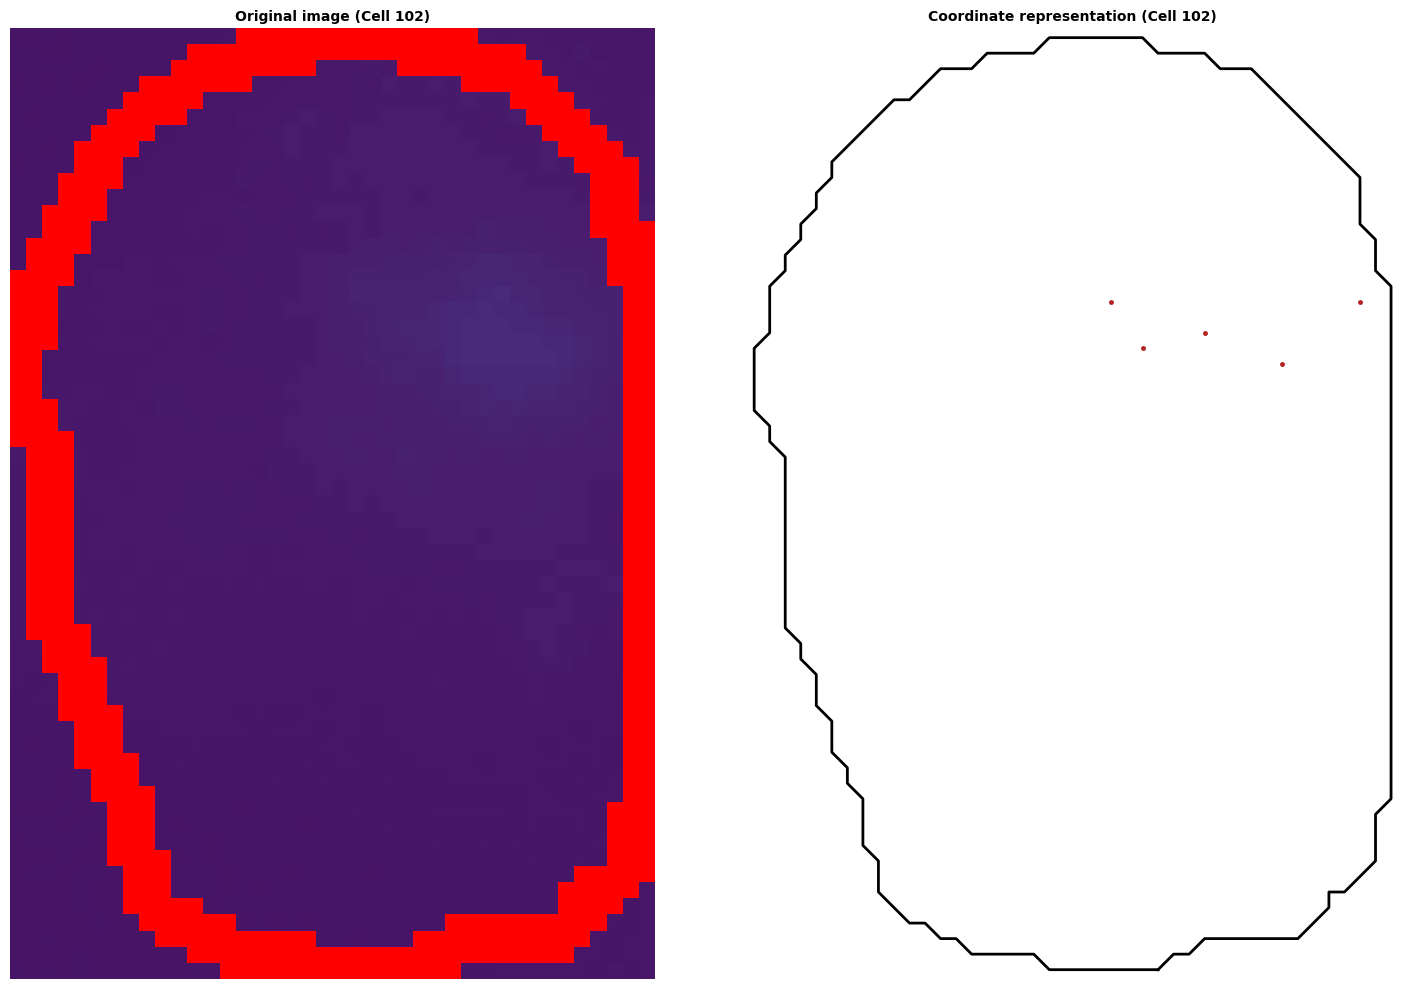

cell 103, mother
 number of rna 2


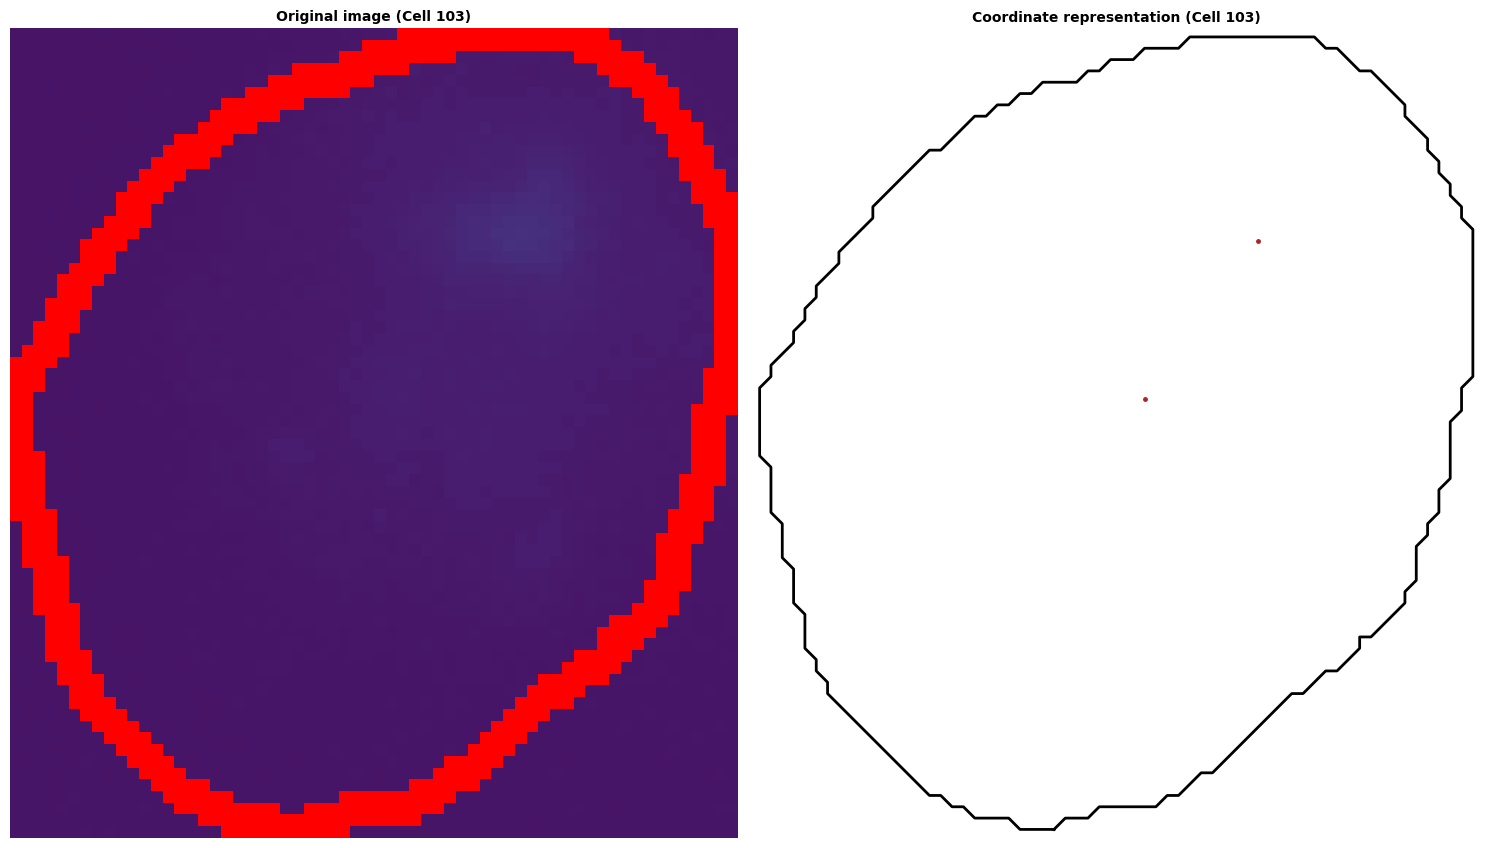

cell 104, bud
 number of rna 0


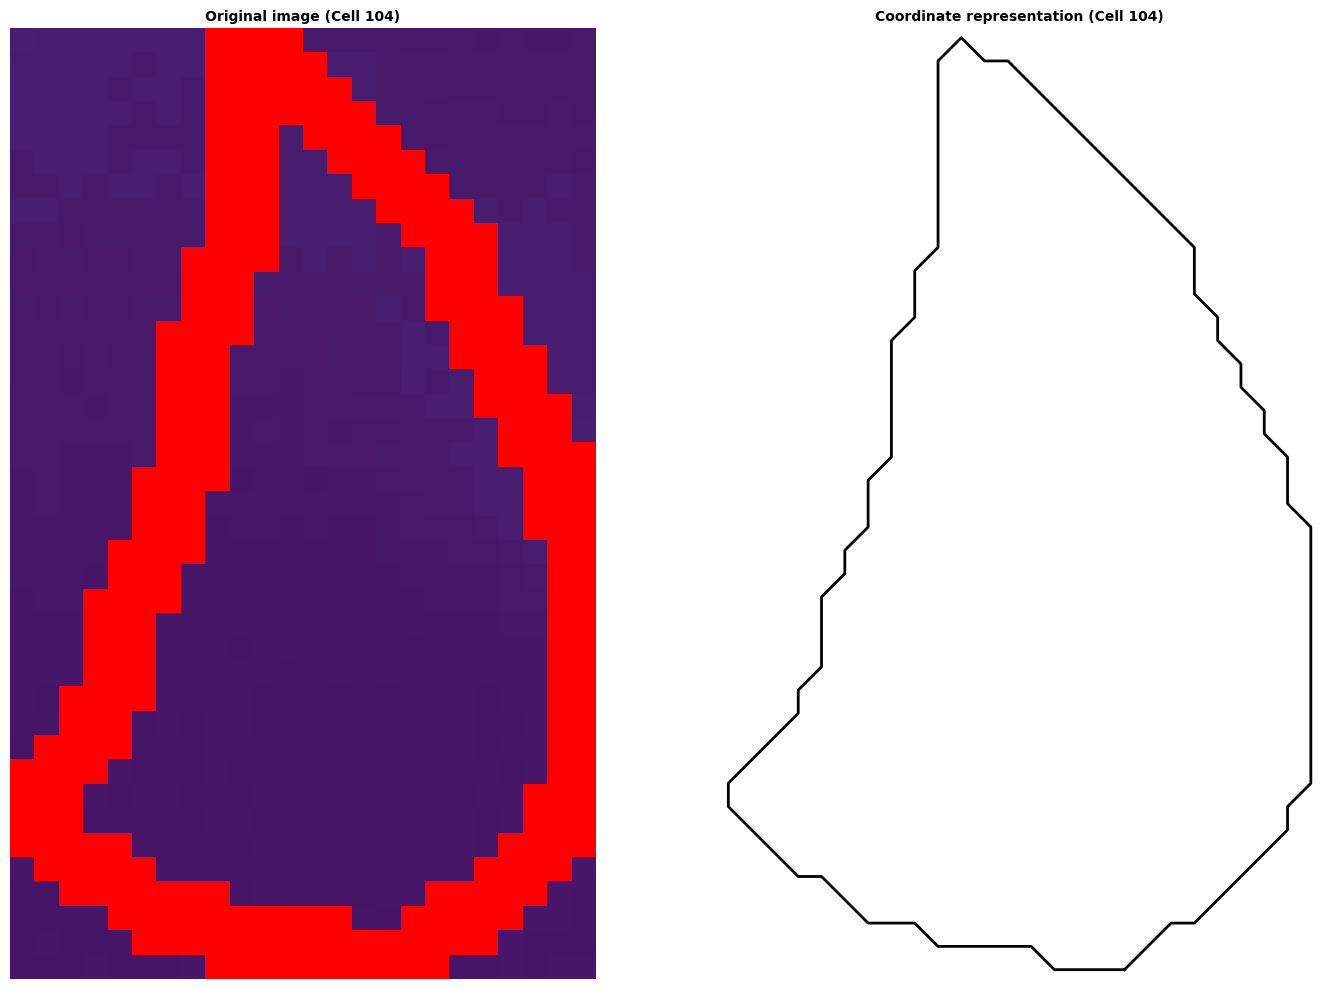

In [310]:
for i in mother_bud_dict.keys():
    cell_results = fov_sep[i]
    print(f"cell {i}, {mother_bud_dict[i]}")
    
    cell_mask = cell_results["cell_mask"]
    cell_coord = cell_results["cell_coord"]
    rna_coord = cell_results["rna_coord"]
    cy3_coord = cell_results['CY3']
    cy35_coord = cell_results['CY3.5']
    image_contrasted = cell_results["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    
    
    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord,
        #nuc_coord=nuc_coord, 
        rna_coord=rna_coord,
        #foci_coord=foci_coord, other_coord=ts_coord, 
        image=image_contrasted, cell_mask=cell_mask, 
        #nuc_mask=nuc_mask, 
        title="Cell {0}".format(i))
    

In [352]:
viewer= napari.Viewer()
napari_view_spots(corresponding_files, np.array(projection), fov_RNA_coordinate_translator(68, fov_sep, 'CY3'))
viewer.add_shapes([mask_sep_coords[67], mask_sep_coords[68]], shape_type='polygon', edge_width=2, edge_color='coral', face_color='transparent')
#viewer.add_shapes(overlap_whole, shape_type='polygon', edge_width=2, edge_color='blue', face_color='transparent')

<Shapes layer 'Shapes' at 0x1be22cec5e0>

In [336]:
fov_sep[65]['rna_coord'][:,1:]

array([[17, 25],
       [25, 32]], dtype=int64)

In [339]:
fov_sep[65]['rna_coord']

array([[26, 17, 25],
       [26, 25, 32]], dtype=int64)

In [343]:
fov_RNA_coordinate_translator(65, fov_sep)

array([[ 99, 437],
       [107, 444]], dtype=int64)

In [ ]:
[mask_sep_coords[65], mask_sep_coords[66]]